In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
from sklearn import set_config
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    MaxAbsScaler,
    RobustScaler,
)
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.compose import ColumnTransformer
import plotly.graph_objects as go

set_config(transform_output="pandas")

df = pd.read_csv("wine_quality_merged.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


Le but de ce projet est de développer un modèle capable de déterminer si un vin Vinho Verde portugais est rouge ou blanc à partir de ses seules caractéristiques physico chimiques. Dans notre cas, il est très important de limiter les erreurs de prédiction sur les deux classes 0 et 1, car prédire qu’un vin blanc est rouge est autant problématique que prédire qu’un vin rouge est blanc.

L’application visée est le contrôle qualité et la détection de faux blancs, ce qui constitue un enjeu métier de niveau moyen à élevé, d’autant que ce modèle ne sera jamais le seul à décider. Des analyses complémentaires seraient réalisées en amont en cas de divergence entre la couleur réelle et la prédiction. En clair, le modèle indiquera si un vin présente un profil physico chimique typique d’un rouge ou d’un blanc.

Dans un contexte où une erreur sur la couleur a un impact métier de niveau moyen à élevé, je considère que le modèle doit atteindre, sur le jeu de test, les objectifs de performance suivants :

Accuracy ≥ 0,96

Par classe, red et white

Précision red ≥ 0,94

Précision white ≥ 0,94

Rappel red ≥ 0,94

Rappel white ≥ 0,94

F1 red ≥ 0,94

F1 white ≥ 0,94

ROC AUC

≥ 0,985

La première étape consiste à supprimer la variable « qualité », car il ne s’agit pas d’une variable physico chimique.

In [2]:
df.drop("quality", axis=1, inplace=True)
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,red
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,white


Examinons maintenant s’il existe des valeurs manquantes.

In [3]:
df.isna().value_counts()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH     sulphates  alcohol  type 
False          False             False        False           False      False                False                 False    False  False      False    False    6497
Name: count, dtype: int64

On n’observe aucune valeur manquante.

# I) Description des variables

* **fixed acidity** : concentration massique en acide tartrique (g/dm3, soit g/L), variable continue
* **volatile acidity** : concentration massique en acide acétique (g/dm3, soit g/L), variable continue
* **citric acid** : concentration massique en acide citrique (g/dm3, soit g/L), variable continue
* **residual sugar** : concentration massique en sucre résiduel (g/dm3, soit g/L), variable continue
* **chlorides** : concentration massique en chlorure de sodium (NaCl) (g/dm3, soit g/L), variable continue
* **free sulfur dioxide** : concentration massique en SO2 libre (g/dm3, soit g/L), variable continue
* **total sulfur dioxide** : concentration massique en SO2 total (g/dm3, soit g/L), variable continue
* **density** : densité du vin (g/cm3), variable continue
* **pH** : pH du vin (sans unité), variable continue
* **sulphates** : concentration massique en sulfates (SO4²⁻) (g/dm3, soit g/L), variable continue
* **alcohol** : degré d’alcool (% volumique), variable continue
* **type** : type de vin (rouge ou blanc), variable discrète, cible du modèle

Étant donné que le Vinho Verde est un vin spécifique soumis à des conditions strictes dans la législation portugaise, nous avons recherché dans des sources fiables les critères permettant d’appeler un vin Vinho Verde. Les conditions retenues, avec leurs références, sont les suivantes.

**BLANC :**

* Degré d’alcool compris entre 8 et 14 degrés
* Acidité fixe minimale de 4,5 g/L
* Acidité volatile ne dépassant pas 1,08 g d’acide acétique par litre
* Acide citrique inférieur ou égal à 1 g/L
* Concentration en NaCl inférieure ou égale à 1 g/L
* SO2 total : si le vin a une teneur en sucre résiduel ≤ 5 g/L, le SO2 total doit être inférieur à 210 mg/L, sinon, si le sucre résiduel est > 5 g/L, le vin doit avoir moins de 300 mg/L
* Sulfates inférieurs à 2 g/L

**ROUGE :**

* Acidité volatile ne dépassant pas 1,20 g d’acide acétique par litre
* SO2 total : si le vin a une teneur en sucre résiduel ≤ 5 g/L, le SO2 total doit être inférieur à 160 mg/L, sinon, si le sucre résiduel est > 5 g/L, le vin doit avoir moins de 210 mg/L
* Le reste des critères est identique à ceux du blanc

Citations :

* [https://diariodarepublica.pt/dr/detalhe/decreto-lei/10-150313](https://diariodarepublica.pt/dr/detalhe/decreto-lei/10-150313)
* [https://webgate.ec.europa.eu/eambrosia-api/api/v1/attachments/16925](https://webgate.ec.europa.eu/eambrosia-api/api/v1/attachments/16925)
* [https://www.ivv.gov.pt/np4/89/](https://www.ivv.gov.pt/np4/89/)

Supprimons maintenant les vins qui ne correspondent pas à ces critères.

In [4]:
# Seuils AOP utilisés (à adapter en fonction de l'évolution des normes).
_AOP = {
    "common": {
        "alcohol_min": 8.5,
        "alcohol_max": 14.0,
        "fixed_acidity_min": 4.5,  # g/L (acide tartrique)
        "chlorides_max": 1.0,  # g/L NaCl
        "citric_acid_max": 1.0,  # g/L
    },
    "white": {
        "volatile_acidity_max": 1.08,  # g/L acide acétique
        "so2_total_max_dry": 210,  # mg/L si sucre ≤ 5 g/L
        "so2_total_max_sweet": 300,  # mg/L si sucre > 5 g/L
    },
    "red": {
        "volatile_acidity_max": 1.20,  # g/L acide acétique
        "so2_total_max_dry": 160,  # mg/L si sucre ≤ 5 g/L
        "so2_total_max_sweet": 210,  # mg/L si sucre > 5 g/L
    },
}

_REQUIRED = [
    "type",
    "alcohol",
    "fixed acidity",
    "volatile acidity",
    "residual sugar",
    "chlorides",
    "total sulfur dioxide",
    "citric acid",
]


def filter_vinho_verde_aop(
    df: pd.DataFrame, return_mask: bool = False
) -> pd.DataFrame | pd.Series:
    """
    Filtre les lignes conformes AOP Vinho Verde, blanc ou rouge.
    - df doit contenir les colonnes listées dans _REQUIRED
    - return_mask=True renvoie un masque booléen au lieu du DataFrame filtré
    """
    missing = [c for c in _REQUIRED if c not in df.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes: {missing}")

    d = df.copy()
    color = d["type"].astype(str).str.lower().str.strip()

    # Règles communes
    common = (
        d["alcohol"].between(
            _AOP["common"]["alcohol_min"],
            _AOP["common"]["alcohol_max"],
            inclusive="both",
        )
        & (d["fixed acidity"] >= _AOP["common"]["fixed_acidity_min"])
        & (d["chlorides"] <= _AOP["common"]["chlorides_max"])
        & (d["citric acid"] <= _AOP["common"]["citric_acid_max"])
    )

    low_sugar = (
        d["residual sugar"] <= 5
    )  # définition "sec" opérationnelle pour les plafonds SO2

    # Blanc
    white_mask = (
        color.eq("white")
        & (d["volatile acidity"] <= _AOP["white"]["volatile_acidity_max"])
        & (
            (
                low_sugar
                & (d["total sulfur dioxide"] <= _AOP["white"]["so2_total_max_dry"])
            )
            | (
                ~low_sugar
                & (d["total sulfur dioxide"] <= _AOP["white"]["so2_total_max_sweet"])
            )
        )
    )

    # Rouge
    red_mask = (
        color.eq("red")
        & (d["volatile acidity"] <= _AOP["red"]["volatile_acidity_max"])
        & (
            (
                low_sugar
                & (d["total sulfur dioxide"] <= _AOP["red"]["so2_total_max_dry"])
            )
            | (
                ~low_sugar
                & (d["total sulfur dioxide"] <= _AOP["red"]["so2_total_max_sweet"])
            )
        )
    )

    mask = common & (white_mask | red_mask)
    return mask if return_mask else df[mask].copy()


df = filter_vinho_verde_aop(df)
len(df)

6443

In [5]:
6497 - 6443

54

Dans ce jeu de données, 54 vins ne sont plus considérés aujourd’hui comme des vins Vinho Verde. On constate que les concentrations en SO2 ainsi que la densité ne sont pas exprimées dans la même unité que les autres concentrations. Nous allons donc effectuer les conversions.

In [6]:
df["free sulfur dioxide"] *= 0.001
df["total sulfur dioxide"] *= 0.001
df["density"] *= 1000

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.4,0.70,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,red
1,7.8,0.88,0.00,2.6,0.098,0.025,0.067,996.80,3.20,0.68,9.8,red
2,7.8,0.76,0.04,2.3,0.092,0.015,0.054,997.00,3.26,0.65,9.8,red
3,11.2,0.28,0.56,1.9,0.075,0.017,0.060,998.00,3.16,0.58,9.8,red
4,7.4,0.70,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,red
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,0.024,0.092,991.14,3.27,0.50,11.2,white
6493,6.6,0.32,0.36,8.0,0.047,0.057,0.168,994.90,3.15,0.46,9.6,white
6494,6.5,0.24,0.19,1.2,0.041,0.030,0.111,992.54,2.99,0.46,9.4,white
6495,5.5,0.29,0.30,1.1,0.022,0.020,0.110,988.69,3.34,0.38,12.8,white


In [7]:
train_set, test_set = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
)
train_set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
2618,8.3,0.14,0.26,1.5,0.049,0.056,0.189,994.60,3.21,0.62,9.5,white
2359,6.9,0.18,0.38,8.1,0.049,0.044,0.176,995.80,3.30,0.54,9.8,white
4924,6.8,0.25,0.28,5.0,0.035,0.042,0.126,990.48,3.12,0.38,12.6,white
6351,5.1,0.25,0.36,1.3,0.035,0.040,0.078,989.10,3.23,0.64,12.1,white
153,7.5,0.60,0.03,1.8,0.095,0.025,0.099,995.00,3.35,0.54,10.1,red
...,...,...,...,...,...,...,...,...,...,...,...,...
3803,7.6,0.27,0.33,2.0,0.059,0.019,0.175,994.40,3.22,0.56,9.9,white
5232,6.6,0.30,0.25,8.0,0.036,0.021,0.124,993.62,3.06,0.38,10.8,white
5267,6.5,0.27,0.26,11.0,0.030,0.002,0.082,994.02,3.07,0.36,11.2,white
5431,6.8,0.31,0.19,3.5,0.086,0.030,0.130,993.00,2.83,0.44,9.6,white


# II) Analyses statistiques

## II.1) Analyse des effectifs par type de vin

In [8]:
train_set["type"].value_counts()

type
white    3903
red      1251
Name: count, dtype: int64

In [9]:
train_set["type"].value_counts(normalize=True)

type
white    0.757276
red      0.242724
Name: proportion, dtype: float64

On observe qu’il y a davantage de vins blancs que de vins rouges. Nous allons donc utiliser comme métrique principale le F1_macro afin d’optimiser le F1 des deux classes pour sélectionner un modèle via GridSearchCV. Il est connu que le raisin blanc contient plus de sucre que le raisin rouge, ce qui peut se traduire par une teneur potentiellement plus élevée en sucre résiduel dans les vins blancs que dans les vins rouges. Il est également admis que les vins blancs contiennent plus de SO2 et de sulfates, et que, de manière générale, les vins rouges sont plus alcoolisés que les vins blancs. Nous allons donc débuter notre analyse exploratoire en examinant ces informations.

## II.2) Analyse des variables potentiellement intéressantes

### II.2.1) Analyse univariée

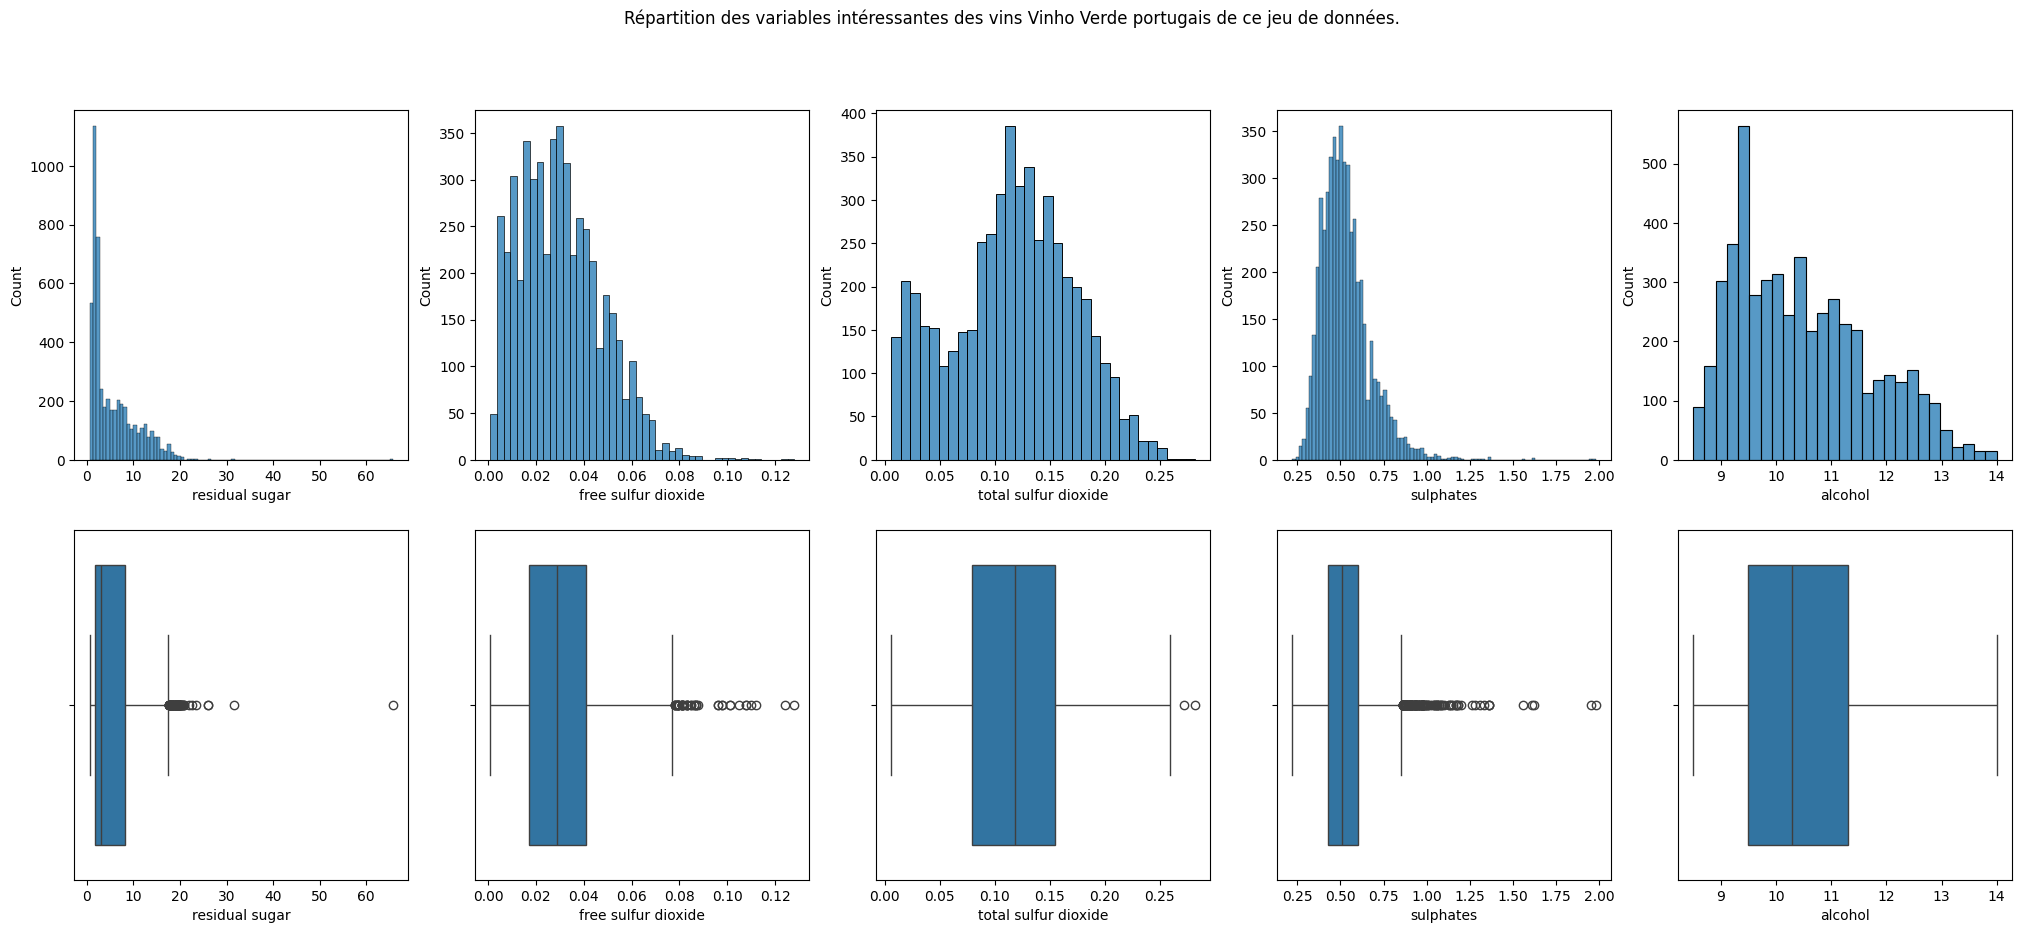

,residual sugar,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
count,5154.000000,5154.000000,5154.000000,5154.000000,5154.000000
mean,5.490114,0.030383,0.115612,0.530691,10.489071
std,4.789739,0.017169,0.055617,0.145428,1.183210
min,0.600000,0.001000,0.006000,0.220000,8.500000
25%,1.800000,0.017000,0.079000,0.430000,9.500000
50%,3.100000,0.029000,0.118000,0.510000,10.300000
75%,8.100000,0.041000,0.155000,0.600000,11.300000
max,65.800000,0.128000,0.282000,1.980000,14.000000


In [10]:
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables intéressantes des vins Vinho Verde portugais de ce jeu de données."
)
sns.histplot(data=train_set, x="residual sugar", ax=ax[0, 0])
sns.boxplot(data=train_set, x="residual sugar", ax=ax[1, 0])
sns.histplot(data=train_set, x="free sulfur dioxide", ax=ax[0, 1])
sns.boxplot(data=train_set, x="free sulfur dioxide", ax=ax[1, 1])
sns.histplot(data=train_set, x="total sulfur dioxide", ax=ax[0, 2])
sns.boxplot(data=train_set, x="total sulfur dioxide", ax=ax[1, 2])
sns.histplot(data=train_set, x="sulphates", ax=ax[0, 3])
sns.boxplot(data=train_set, x="sulphates", ax=ax[1, 3])
sns.histplot(data=train_set, x="alcohol", ax=ax[0, 4])
sns.boxplot(data=train_set, x="alcohol", ax=ax[1, 4])
plt.show()
train_set[
    [
        "residual sugar",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "sulphates",
        "alcohol",
    ]
].describe()

Les vins Vinho Verde portugais de ce jeu de données présentent en moyenne 5.472 g/L de sucre résiduel, 0.031 g/L de SO2 libre, 0.116 g/L de SO2 total, 0.531 g/L de sulfates, et un degré d’alcool moyen de 10.484°. On observe que seule la concentration en sucre résiduel ne suit pas une loi normale. On identifie un vin beaucoup plus concentré en sucre résiduel, considéré comme un outlier, mais cela ne signifie rien en soi. Au delà de 45 g/L de sucre résiduel, le vin est de type vendange tardive. Il existe d’autres outliers pour le sucre résiduel et pour les autres variables, mais ils restent proches les uns des autres.

### II.2.2) Analyse multivariée avec la variable cible

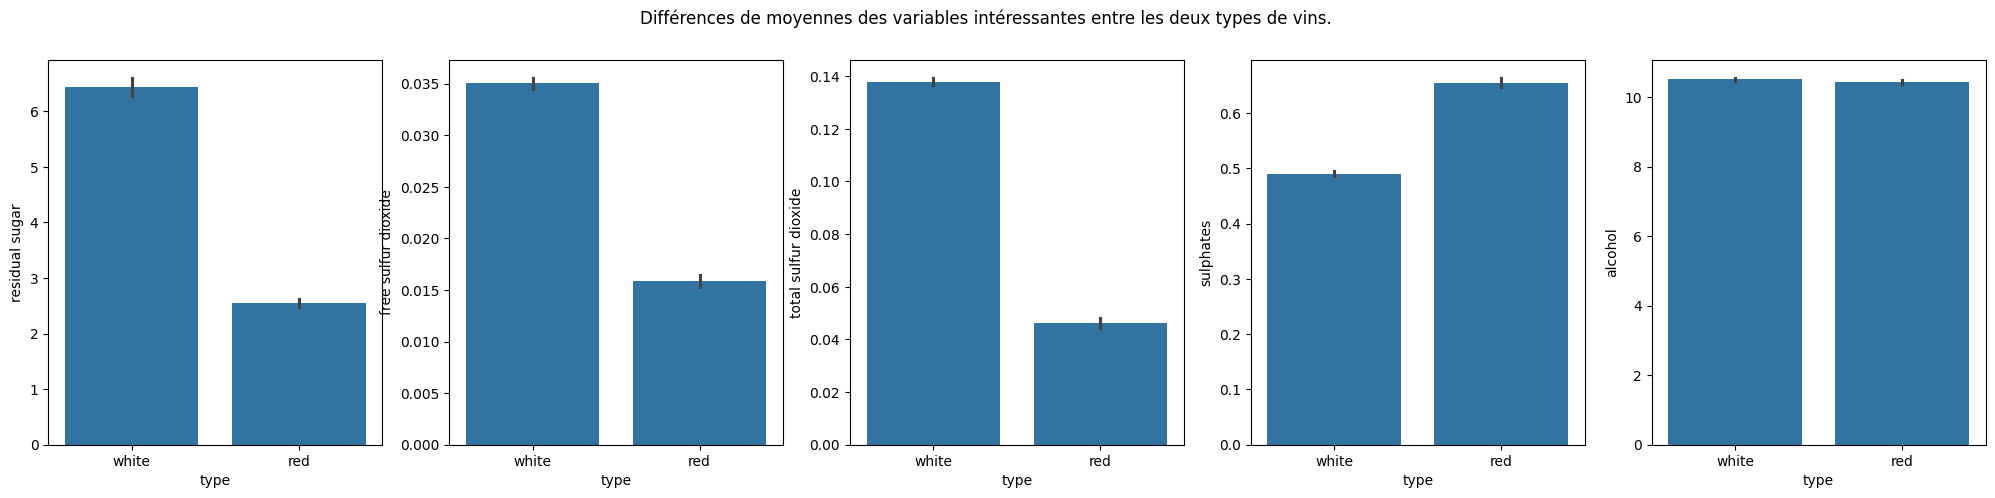

In [11]:
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Différences de moyennes des variables intéressantes entre les deux types de vins."
)
sns.barplot(data=train_set, y="residual sugar", x="type", ax=ax[0])
sns.barplot(data=train_set, y="free sulfur dioxide", x="type", ax=ax[1])
sns.barplot(data=train_set, y="total sulfur dioxide", x="type", ax=ax[2])
sns.barplot(data=train_set, y="sulphates", x="type", ax=ax[3])
sns.barplot(data=train_set, y="alcohol", x="type", ax=ax[4])
plt.show()

On observe que les vins blancs Vinho Verde présentent en moyenne davantage de sucre résiduel, de SO2 libre et de SO2 total, mais une teneur en sulfates plus faible que les vins rouges. Le degré d’alcool moyen est similaire pour les deux types de vins. Contrairement à ce que l’on pouvait penser, les vins rouges contiennent en moyenne plus de sulfates. Passons maintenant à l’analyse des répartitions.

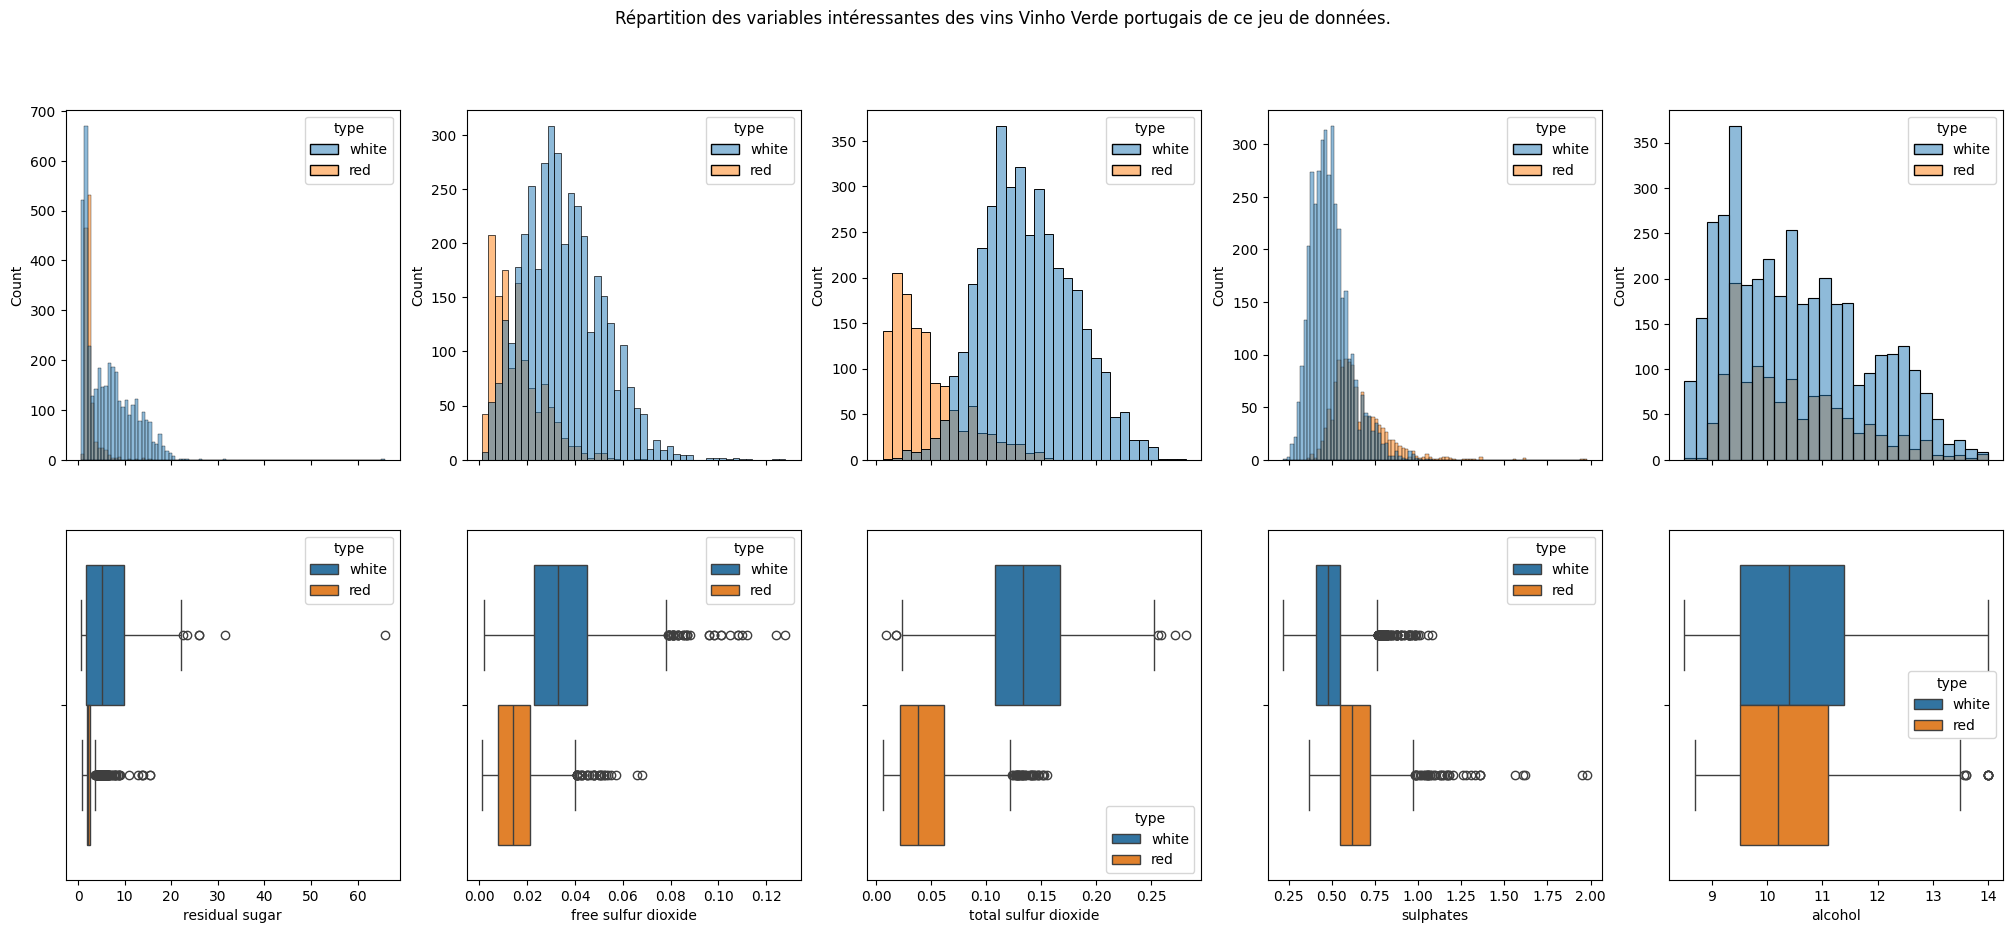

In [12]:
fig, ax = plt.subplots(2, 5, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables intéressantes des vins Vinho Verde portugais de ce jeu de données."
)
sns.histplot(data=train_set, x="residual sugar", hue="type", ax=ax[0, 0])
sns.boxplot(data=train_set, x="residual sugar", hue="type", ax=ax[1, 0])
sns.histplot(data=train_set, x="free sulfur dioxide", hue="type", ax=ax[0, 1])
sns.boxplot(data=train_set, x="free sulfur dioxide", hue="type", ax=ax[1, 1])
sns.histplot(data=train_set, x="total sulfur dioxide", hue="type", ax=ax[0, 2])
sns.boxplot(data=train_set, x="total sulfur dioxide", hue="type", ax=ax[1, 2])
sns.histplot(data=train_set, x="sulphates", hue="type", ax=ax[0, 3])
sns.boxplot(data=train_set, x="sulphates", hue="type", ax=ax[1, 3])
sns.histplot(data=train_set, x="alcohol", hue="type", ax=ax[0, 4])
sns.boxplot(data=train_set, x="alcohol", hue="type", ax=ax[1, 4])
plt.show()

On observe que les histogrammes et boxplots des quatre premières variables sont décalés, ce qui laisse déjà apparaître une certaine séparation entre les deux types de vins. En revanche, pour le degré d’alcool, on constate une superposition quasi totale des histogrammes ainsi que des boxplots. La séparation devient plus nette lorsque l’on considère la concentration totale en SO2. Avant de passer aux tests d’hypothèses, il est nécessaire de vérifier les conditions d’application.

In [13]:
train_set.groupby("type")[
    [
        "residual sugar",
        "free sulfur dioxide",
        "total sulfur dioxide",
        "sulphates",
        "alcohol",
    ]
].std()

,residual sugar,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol
type,,,,,
red,1.382819,0.010302,0.031533,0.16065,1.054768
white,5.100361,0.016305,0.041494,0.11453,1.221067


1. Toutes les caractéristiques physico chimiques de ce jeu de données, pour un vin donné, ne dépendent pas les unes des autres.

2. Il s’agit exclusivement de vins de type Vinho Verde portugais, ils proviennent donc tous de la même population.

3. Il y a plus de 30 observations dans chaque catégorie de la variable cible.

4. On constate que la différence d’écarts types est trop importante pour utiliser un test de Student sur le sucre résiduel, mais ce n’est pas le cas pour les autres variables.

In [14]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en sucre résiduel que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["residual sugar"],
    train_set.query("`type` == 'white'")["residual sugar"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en sucre résiduel que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [15]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en SO2 libre que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["free sulfur dioxide"],
    train_set.query("`type` == 'white'")["free sulfur dioxide"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en SO2 libre que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [16]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en SO2 total que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["total sulfur dioxide"],
    train_set.query("`type` == 'white'")["total sulfur dioxide"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en SO2 total que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [17]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en sulfates que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["sulphates"],
    train_set.query("`type` == 'white'")["sulphates"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en sulfates que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [18]:
print("H0: Les vins rouge ont en moyenne le même degrés d'alcool que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["alcohol"],
    train_set.query("`type` == 'white'")["alcohol"],
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne le même degrés d'alcool que les vins blanc.
Nous n'avons pas assez d'évidence pour rejeter H0.


Sans surprise, nous avons rejeté H0 pour les concentrations en sucre résiduel, en SO2 libre et en SO2 total, ainsi que pour la concentration en sulfates. En revanche, nous n’avons pas réussi à rejeter H0 pour l’alcool. Par conséquent, nous pourrons supprimer cette variable lors du préprocessing.

### II.2.3) Analyse des variables intéressantes entre elles.

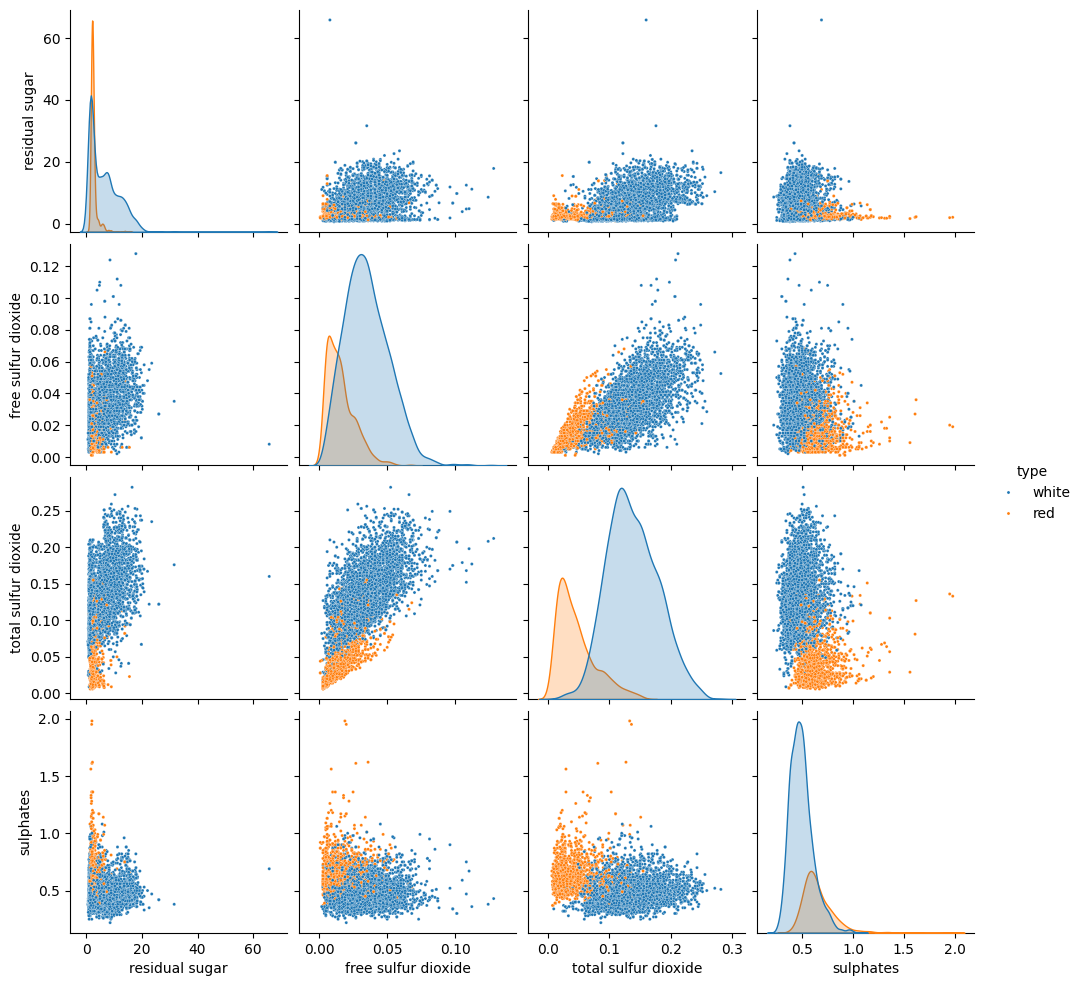

In [19]:
fig = sns.pairplot(
    train_set[
        [
            "residual sugar",
            "free sulfur dioxide",
            "total sulfur dioxide",
            "sulphates",
            "type",
        ]
    ],
    hue="type",
    plot_kws={"s": 5},
)
plt.show()

On observe que les relations entre "free sulfur dioxide" et "total sulfur dioxide", ainsi qu’entre "sulphates" et "total sulfur dioxide", commencent à montrer une séparation intéressante. Effectuons maintenant un zoom sur ces deux relations.

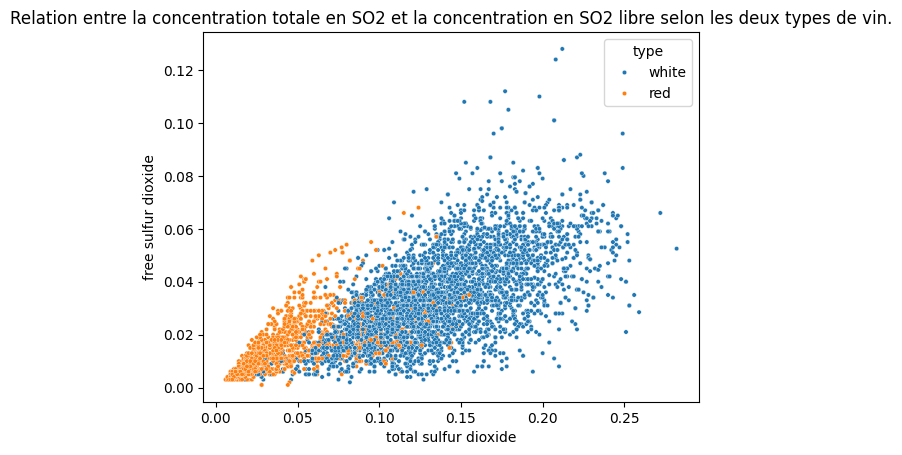

In [20]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="free sulfur dioxide", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et la concentration en SO2 libre selon les deux types de vin."
)
plt.show()

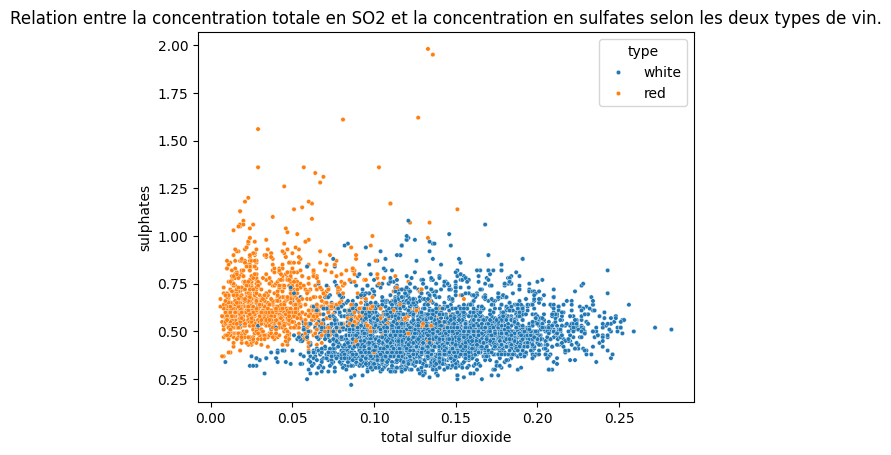

In [21]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="sulphates", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et la concentration en sulfates selon les deux types de vin."
)
plt.show()

On peut déjà envisager de construire un modèle très performant à partir des deux surfaces précédentes. Observons maintenant la surface 3D définie par la concentration en sulfates, le SO2 libre et le SO2 total.

In [22]:
fig = px.scatter_3d(
    train_set,
    x="total sulfur dioxide",
    y="free sulfur dioxide",
    z="sulphates",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre la concentration en sulfates, en SO2 libre et en SO2 total selon les deux types de vin.",
    title_x=0.5,
)

On constate que ces trois variables permettent déjà de construire un modèle assez performant, même si une certaine superposition persiste. Nous allons donc poursuivre l’analyse avec les autres variables.

## II.3) Analyse des variables d’acidité

### II.3.1) Analyse univariée

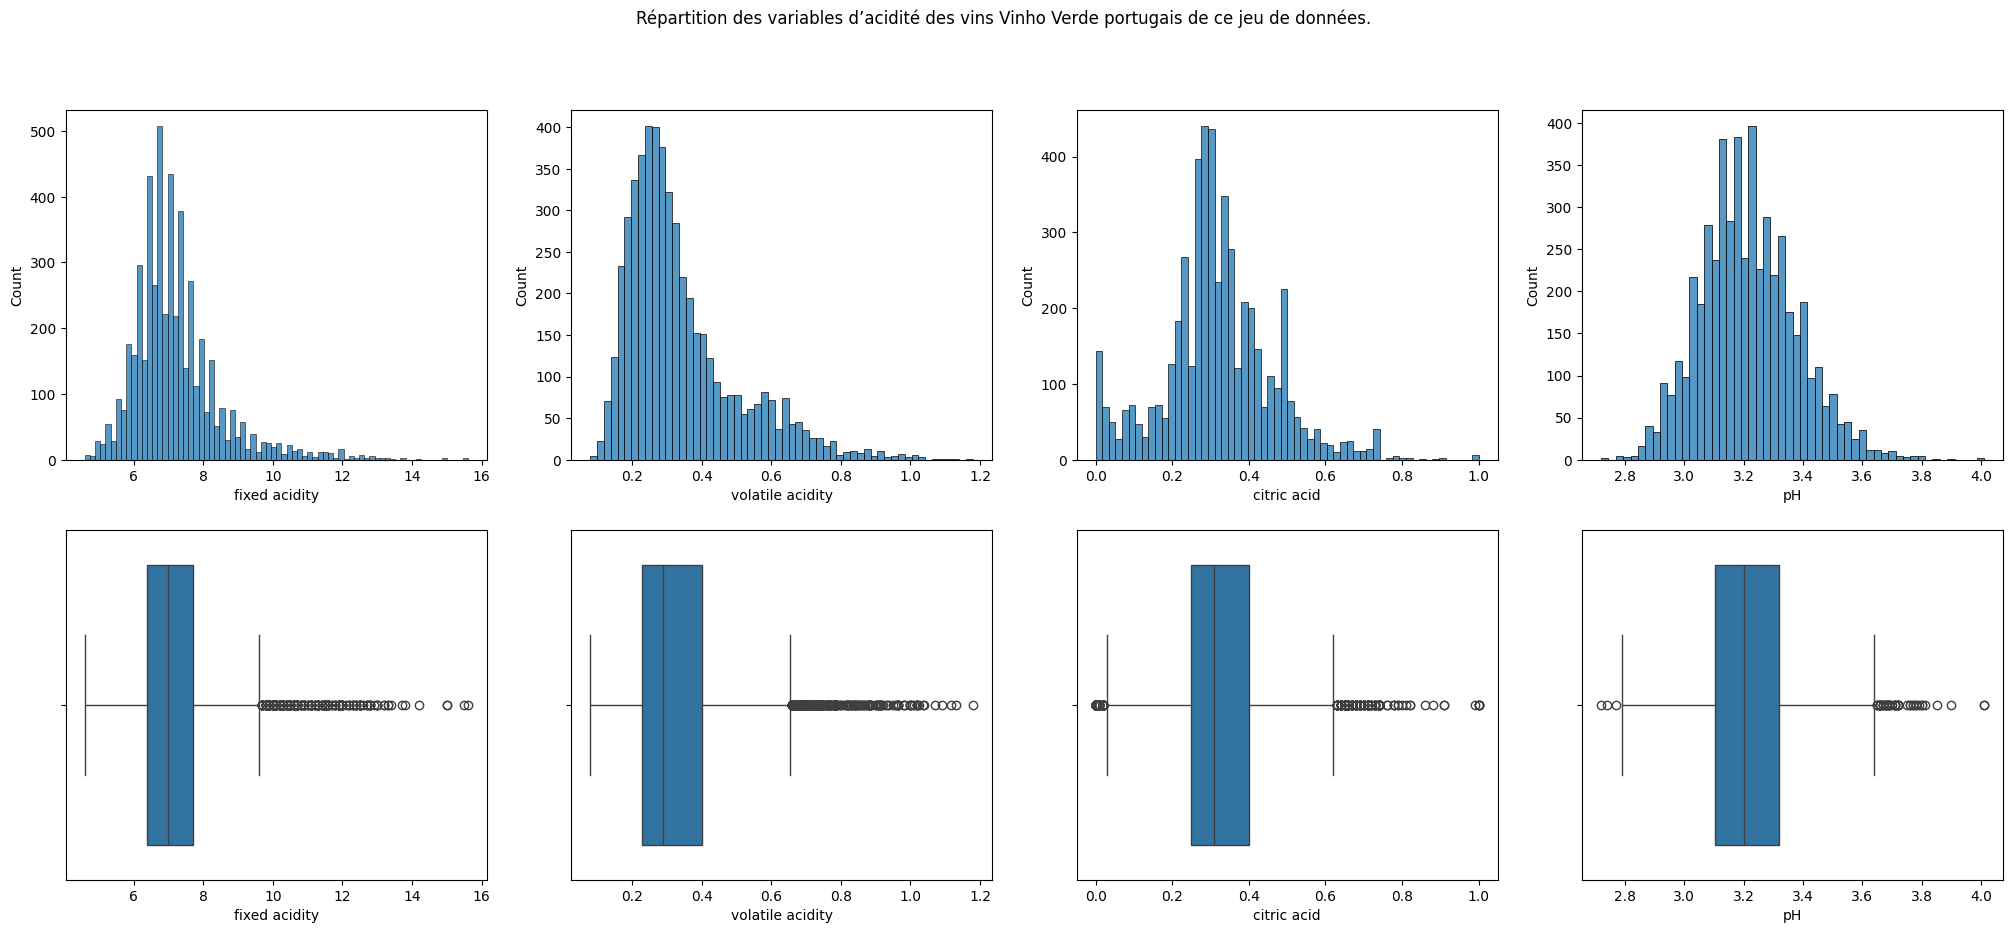

,fixed acidity,volatile acidity,citric acid,pH
count,5154.000000,5154.000000,5154.000000,5154.000000
mean,7.209682,0.338154,0.318694,3.216013
std,1.265865,0.162633,0.143715,0.161007
min,4.600000,0.080000,0.000000,2.720000
25%,6.400000,0.230000,0.250000,3.102500
50%,7.000000,0.290000,0.310000,3.200000
75%,7.700000,0.400000,0.400000,3.320000
max,15.600000,1.180000,1.000000,4.010000


In [23]:
fig, ax = plt.subplots(2, 4)
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables d’acidité des vins Vinho Verde portugais de ce jeu de données."
)
sns.histplot(data=train_set, x="fixed acidity", ax=ax[0, 0])
sns.boxplot(data=train_set, x="fixed acidity", ax=ax[1, 0])
sns.histplot(data=train_set, x="volatile acidity", ax=ax[0, 1])
sns.boxplot(data=train_set, x="volatile acidity", ax=ax[1, 1])
sns.histplot(data=train_set, x="citric acid", ax=ax[0, 2])
sns.boxplot(data=train_set, x="citric acid", ax=ax[1, 2])
sns.histplot(data=train_set, x="pH", ax=ax[0, 3])
sns.boxplot(data=train_set, x="pH", ax=ax[1, 3])
plt.show()
train_set[
    [
        "fixed acidity",
        "volatile acidity",
        "citric acid",
        "pH",
    ]
].describe()

Les vins Vinho Verde portugais rouges et blancs de ce jeu de données présentent en moyenne 7.210 g/L d’acidité fixe, 0.338 g/L d’acidité volatile, 0.319 g/L d’acide citrique et un pH moyen de 3.216, ce qui correspond à un milieu acide. On remarque que certains vins ne contiennent pas d’acide citrique. Les quatre variables d’acidité suivent une distribution normale. On observe des outliers relativement proches de la boîte à moustaches et proches les uns des autres.

### II.3.2) Analyse des variables d’acidité avec le type de vin

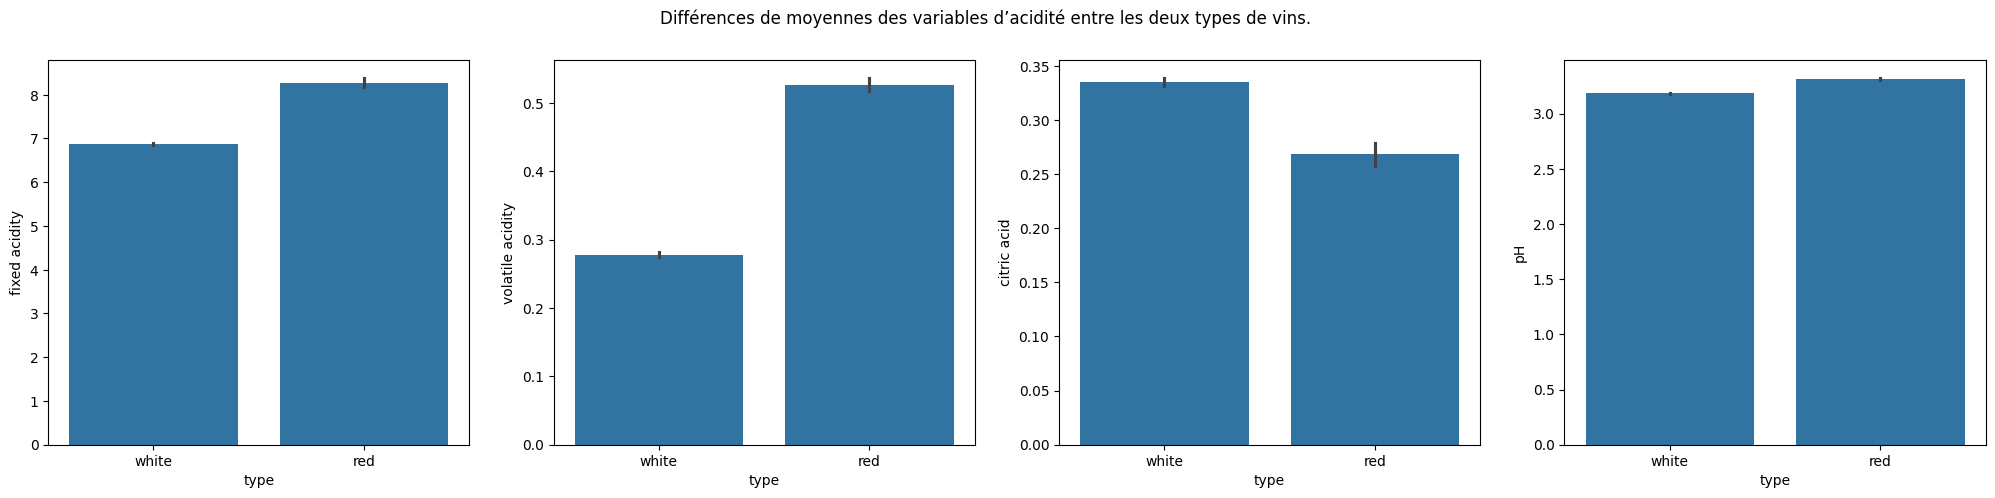

In [24]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Différences de moyennes des variables d’acidité entre les deux types de vins."
)
sns.barplot(data=train_set, y="fixed acidity", x="type", ax=ax[0])
sns.barplot(data=train_set, y="volatile acidity", x="type", ax=ax[1])
sns.barplot(data=train_set, y="citric acid", x="type", ax=ax[2])
sns.barplot(data=train_set, y="pH", x="type", ax=ax[3])
plt.show()

On observe qu’il y a en moyenne une concentration plus élevée en acide tartrique, donc en acidité fixe, et en acide citrique dans les vins blancs que dans les vins rouges. À l’inverse, la concentration moyenne en acide acétique, donc en acidité volatile, ainsi que le pH sont plus élevés pour les vins rouges que pour les vins blancs. La plus grande différence apparaît au niveau de la concentration en acide acétique, tandis que la plus faible différence concerne le pH, ce qui est logique puisque le vin est une solution tampon, le pH ne doit donc pas beaucoup varier entre les deux types de vins.

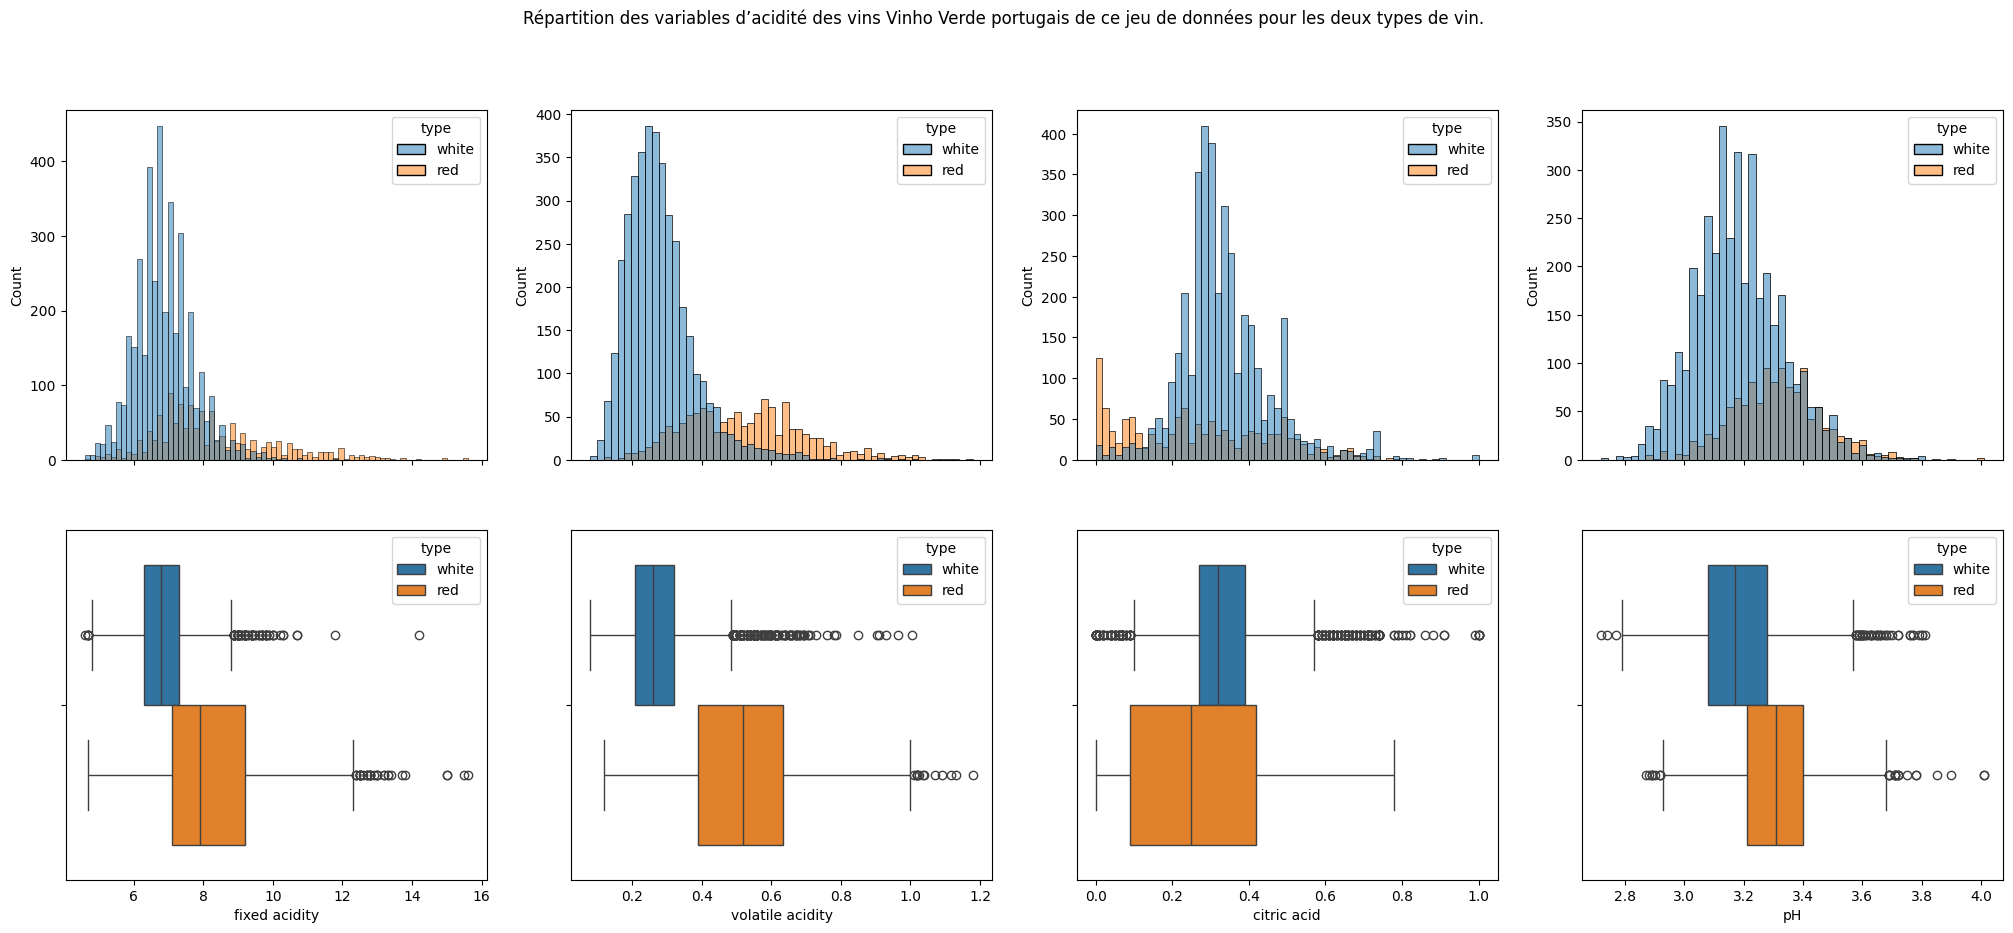

In [25]:
fig, ax = plt.subplots(2, 4, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables d’acidité des vins Vinho Verde portugais de ce jeu de données pour les deux types de vin."
)
sns.histplot(data=train_set, x="fixed acidity", hue="type", ax=ax[0, 0])
sns.boxplot(data=train_set, x="fixed acidity", hue="type", ax=ax[1, 0])
sns.histplot(data=train_set, x="volatile acidity", hue="type", ax=ax[0, 1])
sns.boxplot(data=train_set, x="volatile acidity", hue="type", ax=ax[1, 1])
sns.histplot(data=train_set, x="citric acid", hue="type", ax=ax[0, 2])
sns.boxplot(data=train_set, x="citric acid", hue="type", ax=ax[1, 2])
sns.histplot(data=train_set, x="pH", hue="type", ax=ax[0, 3])
sns.boxplot(data=train_set, x="pH", hue="type", ax=ax[1, 3])
plt.show()

On observe des différences intéressantes dans les répartitions pour l’acidité fixe et surtout pour l’acidité volatile. Les vins rouges présentent un domaine de variation plus large que les vins blancs pour les trois concentrations en acide. Même si l’on constate une superposition des deux histogrammes pour le pH, on observe un décalage entre les deux distributions, mais cela reste la variable la moins intéressante parmi les variables d’acidité. Procédons maintenant aux tests d’hypothèses.

In [26]:
train_set.groupby("type")[
    ["fixed acidity", "volatile acidity", "citric acid", "pH"]
].std()

,fixed acidity,volatile acidity,citric acid,pH
type,,,,
red,1.697722,0.174866,0.191821,0.153235
white,0.841789,0.100777,0.120057,0.150334


Globalement, les différences d’écarts types sont suffisamment faibles pour utiliser le test de Student. Les autres conditions d’application ont déjà été vérifiées.

In [27]:
print("H0: Les vins rouge ont en moyenne la même acidité fixe que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["fixed acidity"],
    train_set.query("`type` == 'white'")["fixed acidity"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même acidité fixe que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [28]:
print("H0: Les vins rouge ont en moyenne la même acidité volatile que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["volatile acidity"],
    train_set.query("`type` == 'white'")["volatile acidity"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même acidité volatile que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [29]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en acide citrique que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["citric acid"],
    train_set.query("`type` == 'white'")["citric acid"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en acide citrique que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [30]:
print("H0: Les vins rouge ont en moyenne le même pH que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["pH"],
    train_set.query("`type` == 'white'")["pH"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne le même pH que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


On constate que nous avons rejeté H0 pour l’ensemble des variables d’acidité. Nous pouvons donc conclure que les moyennes des deux types de vins diffèrent pour chacune des variables d’acidité.

### II.3.3) Analyse des variables d’acidité entre elles

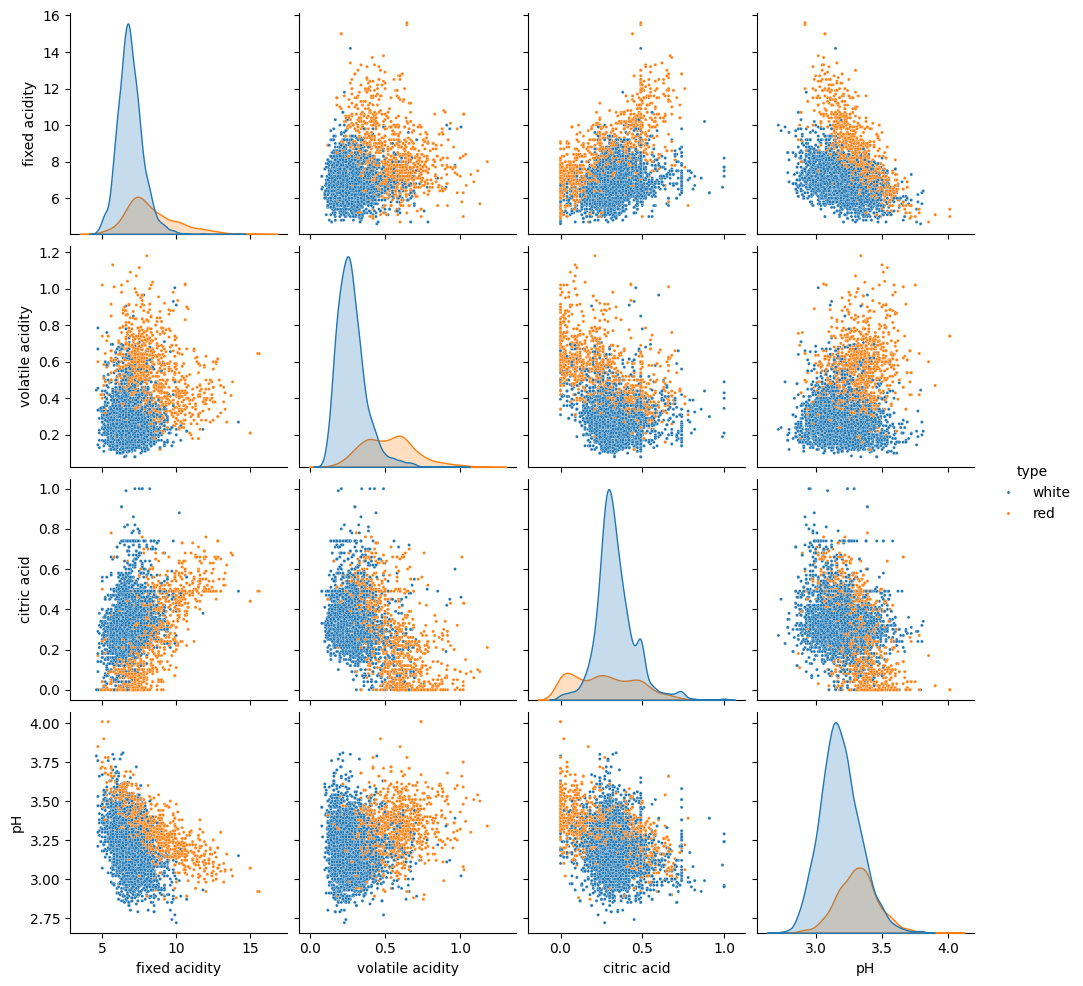

In [31]:
fig = sns.pairplot(
    train_set[["fixed acidity", "volatile acidity", "citric acid", "pH", "type"]],
    hue="type",
    plot_kws={"s": 5},
)
plt.show()

On observe que la majorité des surfaces sont intéressantes, la plus pertinente étant celle définie par "fixed acidity" et "volatile acidity". Nous allons maintenant visualiser en 3D les surfaces les plus intéressantes.

In [32]:
fig = px.scatter_3d(
    train_set,
    x="fixed acidity",
    y="volatile acidity",
    z="citric acid",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre l’acidité fixe, l’acidité volatile et la concentration en acide citrique selon les deux types de vin.",
    title_x=0.5,
)

In [33]:
fig = px.scatter_3d(
    train_set,
    x="fixed acidity",
    y="volatile acidity",
    z="pH",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre l’acidité fixe, l’acidité volatile et la concentration en acide citrique pour les deux types de vin.",
    title_x=0.5,
)

In [34]:
fig = px.scatter_3d(
    train_set,
    x="fixed acidity",
    y="citric acid",
    z="pH",
    color="type",
)
fig.update_traces(
    marker=dict(size=4, line=dict(width=2)),
    selector=dict(mode="markers"),
)
fig.update_layout(
    title_text="Relation entre l’acidité fixe, l’acidité volatile et la concentration en acide citrique pour chacun des deux types de vin.",
    title_x=0.5,
)

On voit que l’on peut définir trois surfaces à partir desquelles on peut construire des modèles assez performants. Maintenant, examinons les relations entre les variables intéressantes et les variables d’acidité.

### II.3.4) Relations entre les variables intéressantes et les variables d’acidité

Au lieu de visualiser l’ensemble des relations, on peut se concentrer directement sur la relation 2D entre la concentration totale en SO2 et l’acidité volatile, qui constituent les deux meilleures variables jusqu’à présent.

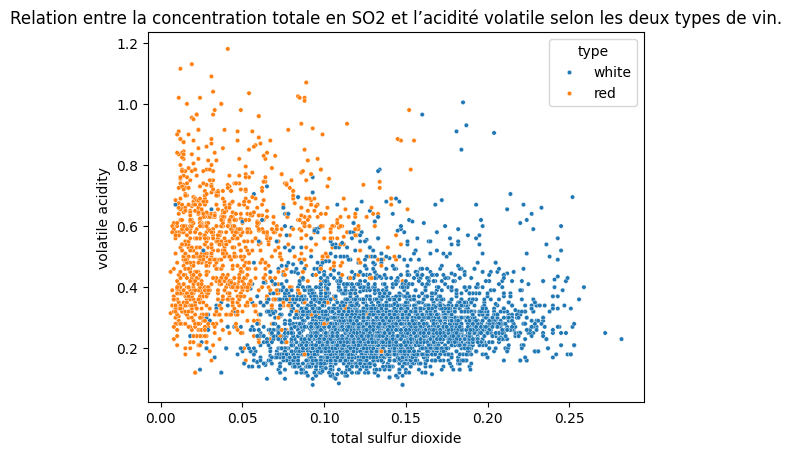

In [35]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="volatile acidity", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et l’acidité volatile selon les deux types de vin."
)
plt.show()

On voit que l’on peut clairement construire un modèle performant à partir de cette surface, mais il nous reste à analyser les deux dernières variables, à savoir la concentration en NaCl et la densité.

## II.4) Analyse de la concentration en NaCl et de la densité

### II.4.1) Analyse univariée

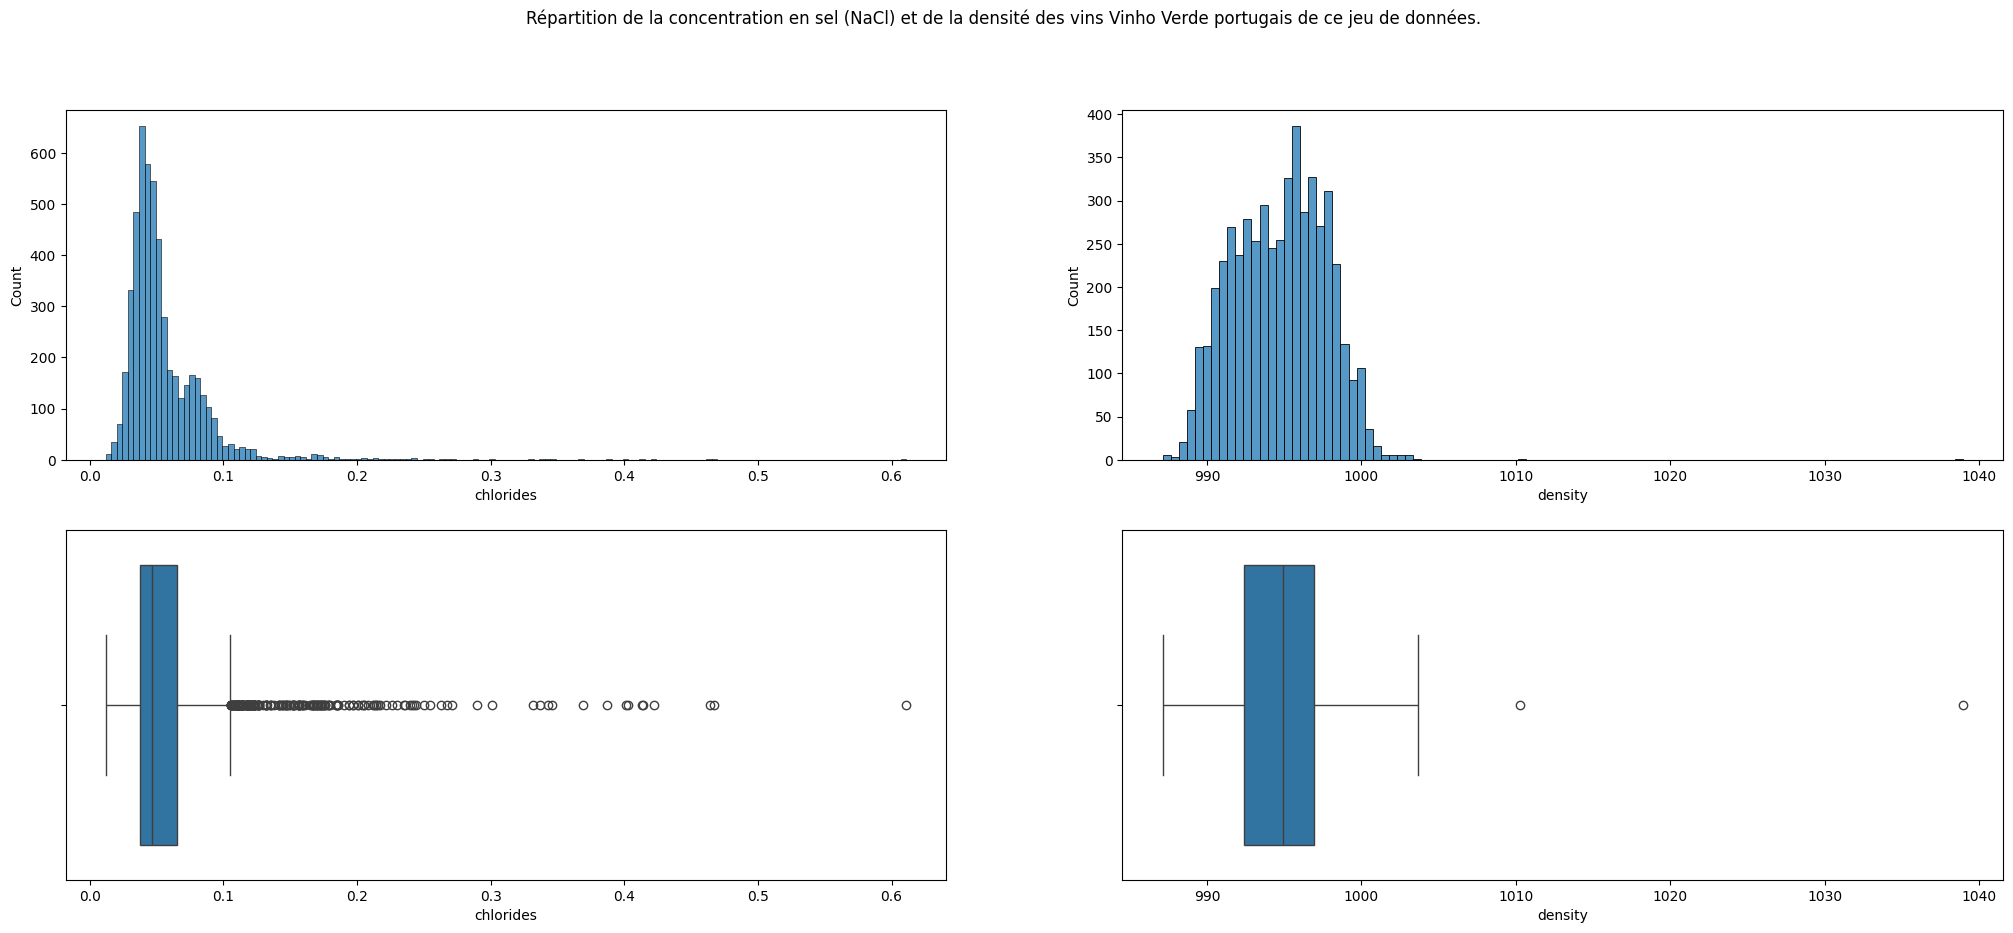

,chlorides,density
count,5154.000000,5154.000000
mean,0.055808,994.694292
std,0.033587,2.987132
min,0.012000,987.110000
25%,0.038000,992.370000
50%,0.047000,994.900000
75%,0.065000,996.920000
max,0.611000,1038.980000


In [36]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition de la concentration en sel (NaCl) et de la densité des vins Vinho Verde portugais de ce jeu de données."
)
sns.histplot(data=train_set, x="chlorides", ax=ax[0, 0])
sns.boxplot(data=train_set, x="chlorides", ax=ax[1, 0])
sns.histplot(data=train_set, x="density", ax=ax[0, 1])
sns.boxplot(data=train_set, x="density", ax=ax[1, 1])
plt.show()
train_set[["chlorides", "density"]].describe()

Les vins Vinho Verde portugais de ce jeu de données présentent en moyenne 0,056 g/L de sel (NaCl) et une densité moyenne de 994,694 g/L, valeur assez proche de celle de l’eau (1000 g/L). Les deux variables suivent clairement une loi normale, avec une série de valeurs aberrantes pour la concentration en sel et seulement deux valeurs aberrantes pour la densité.

### II.4.2) Analyse selon le type de vin

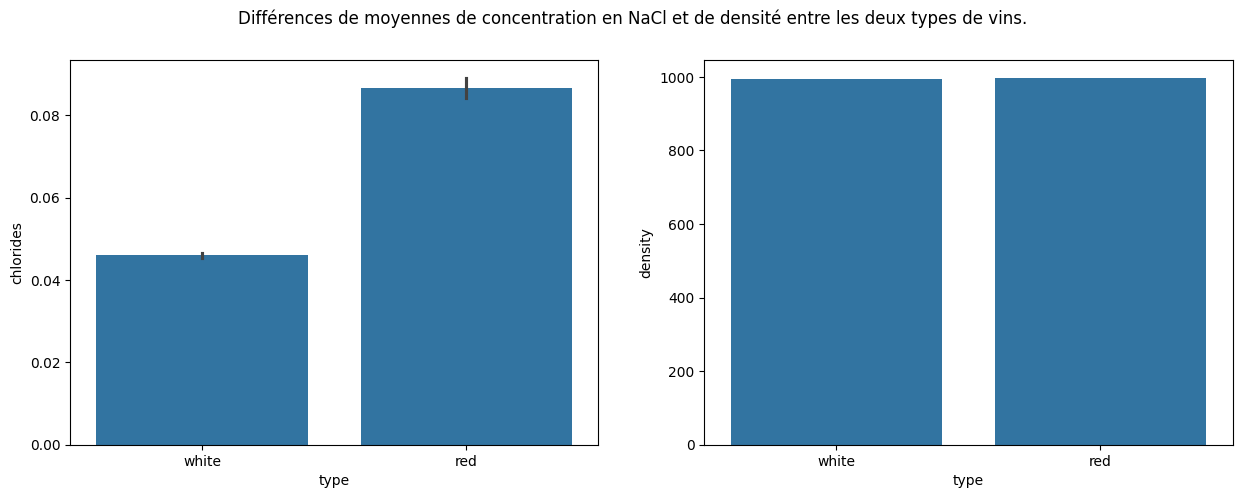

In [37]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
plt.suptitle(
    "Différences de moyennes de concentration en NaCl et de densité entre les deux types de vins."
)
sns.barplot(data=train_set, y="chlorides", x="type", ax=ax[0])
sns.barplot(data=train_set, y="density", x="type", ax=ax[1])
plt.show()

On observe que les vins blancs ont en moyenne une teneur en sel plus faible que les vins rouges, et que les densités, sans surprise, sont équivalentes.

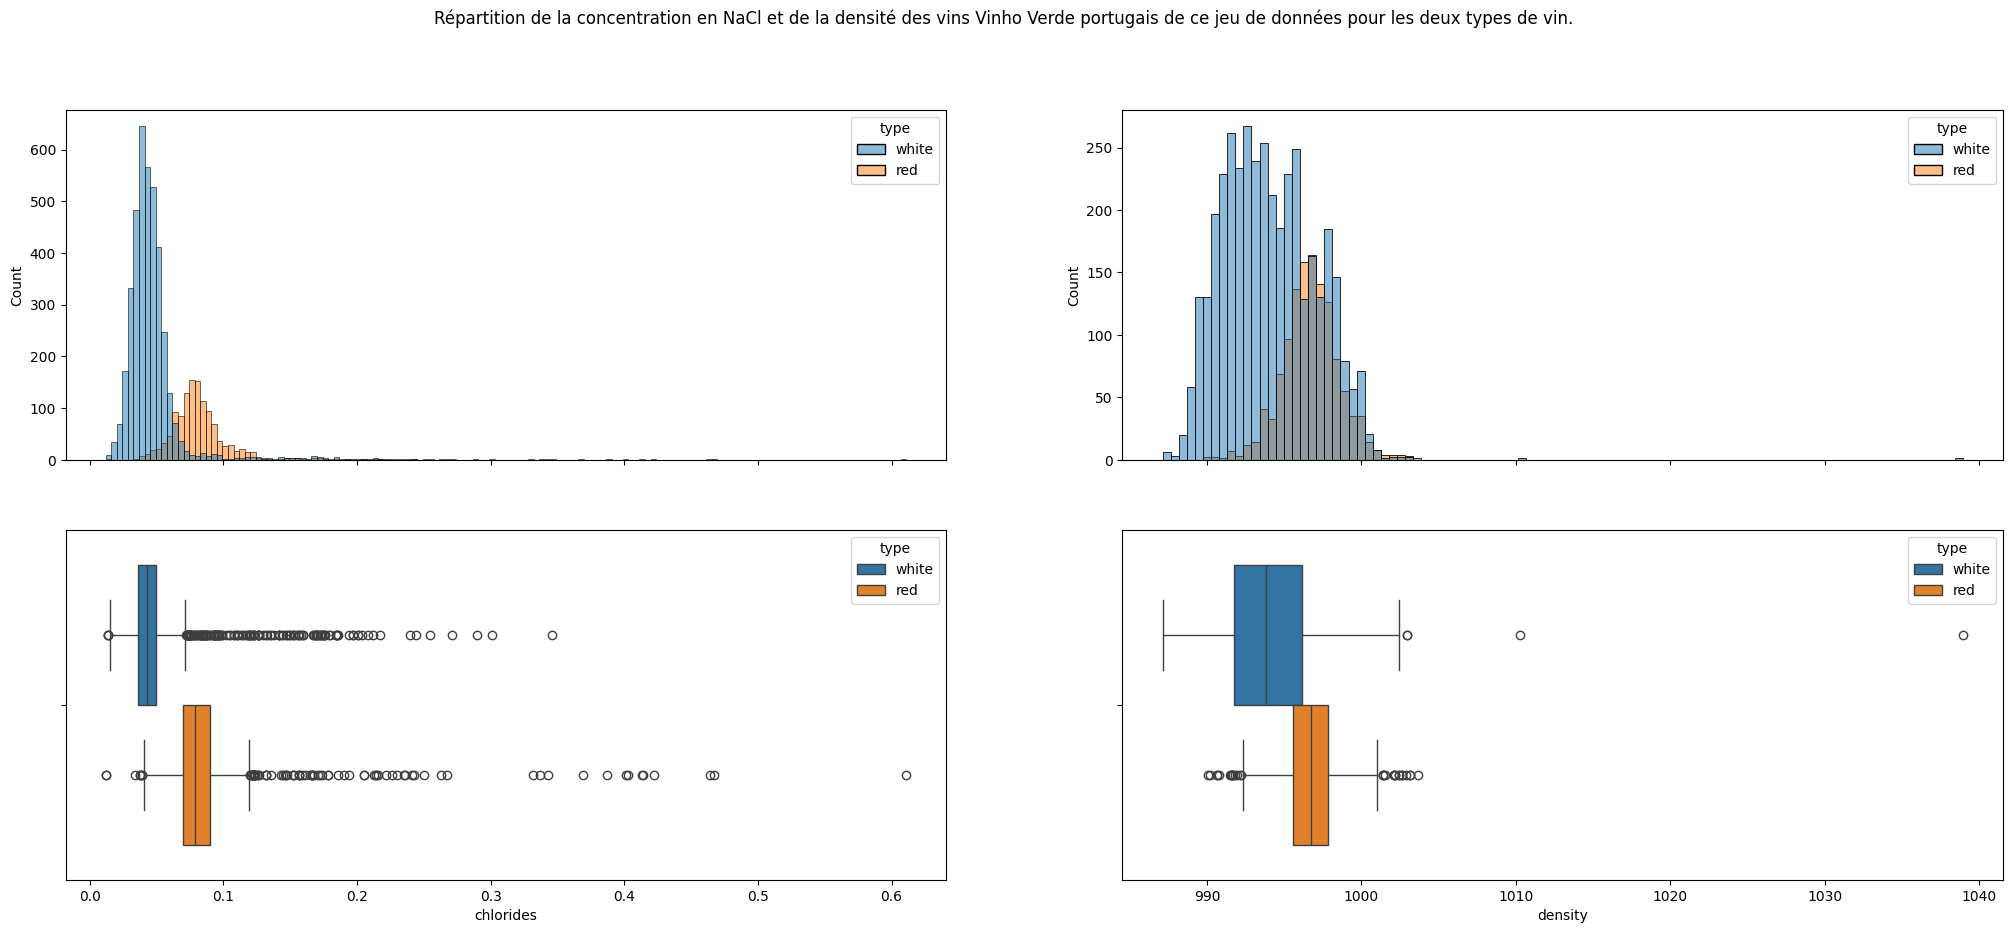

In [38]:
fig, ax = plt.subplots(2, 2, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition de la concentration en NaCl et de la densité des vins Vinho Verde portugais de ce jeu de données pour les deux types de vin."
)
sns.histplot(data=train_set, x="chlorides", hue="type", ax=ax[0, 0])
sns.boxplot(data=train_set, x="chlorides", hue="type", ax=ax[1, 0])
sns.histplot(data=train_set, x="density", hue="type", ax=ax[0, 1])
sns.boxplot(data=train_set, x="density", hue="type", ax=ax[1, 1])
plt.show()

On observe un décalage entre les deux distributions pour ces deux variables, même si ce décalage est surtout marqué pour la concentration en sel. Cette dernière constitue également une variable très importante pour le modèle. Testons maintenant les différences de moyennes à l’aide d’un test de Student.

In [39]:
train_set.groupby("type")[["chlorides", "density"]].std()

,chlorides,density
type,,
red,0.043146,1.843609
white,0.022206,2.994326


On constate que les écarts types sont suffisamment proches pour utiliser un test de Student.

In [40]:
print(
    "H0: Les vins rouge ont en moyenne la même concentration en NaCl que les vins blanc."
)

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["chlorides"],
    train_set.query("`type` == 'white'")["chlorides"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même concentration en NaCl que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


In [41]:
print("H0: Les vins rouge ont en moyenne la même densité que les vins blanc.")

alpha = 0.02

p_value = ttest_ind(
    train_set.query("`type` == 'red'")["density"],
    train_set.query("`type` == 'white'")["density"],
    equal_var=False,
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidence pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les vins rouge ont en moyenne la même densité que les vins blanc.
Nous avons assez d'évidence pour rejeter H0.


Nous avons réussi à rejeter H0 pour les deux variables, les différences observées sont donc significatives.

### II.4.3) Analyse des meilleures variables entre elles

Au lieu d’examiner l’ensemble des relations, nous allons directement analyser les meilleures variables entre elles.

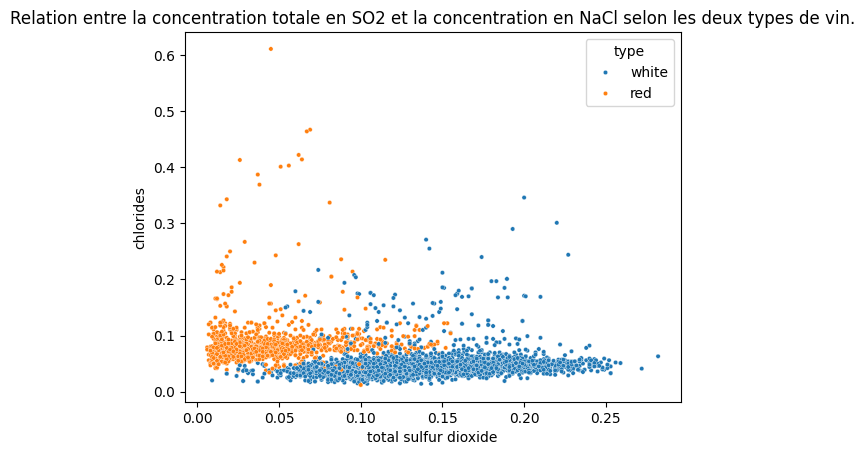

In [42]:
sns.scatterplot(
    data=train_set, x="total sulfur dioxide", y="chlorides", hue="type", s=10
)
plt.title(
    "Relation entre la concentration totale en SO2 et la concentration en NaCl selon les deux types de vin."
)
plt.show()

Cette surface est particulièrement intéressante, car la plupart des vins rouges sont séparés des vins blancs par une droite, même si les deux nuages de points restent proches. En conclusion, seul le degré d’alcool n’est pas informatif et nous avons mis en évidence de nombreuses relations intéressantes.

Il est important de rappeler que les seules mesures obligatoires sont l’acidité fixe, l’acidité volatile, la concentration en acide citrique, la concentration en sucre résiduel, la concentration en NaCl, la concentration en SO2 total, la concentration en sulfates et le degré d’alcool. Même si la mesure du pH et de la densité n’est pas obligatoire, ces deux grandeurs sont généralement déterminées en laboratoire de contrôle qualité et leur acquisition est rapide.

Par conséquent, comme notre objectif est aussi de minimiser les coûts d’analyses, nous allons construire un premier modèle à partir des variables associées aux analyses physico chimiques obligatoires, et si les objectifs ne sont pas atteints, nous pourrons ajouter la densité et le pH.

# III) Premier modèle

In [43]:
X_train = train_set.drop(
    ["type", "alcohol", "pH", "density", "free sulfur dioxide"], axis=1
)
y_train = train_set["type"]
X_test = test_set.drop(
    ["type", "alcohol", "pH", "density", "free sulfur dioxide"], axis=1
)
y_test = test_set["type"]
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,sulphates
2618,8.3,0.14,0.26,1.5,0.049,0.189,0.62
2359,6.9,0.18,0.38,8.1,0.049,0.176,0.54
4924,6.8,0.25,0.28,5.0,0.035,0.126,0.38
6351,5.1,0.25,0.36,1.3,0.035,0.078,0.64
153,7.5,0.60,0.03,1.8,0.095,0.099,0.54
...,...,...,...,...,...,...,...
3803,7.6,0.27,0.33,2.0,0.059,0.175,0.56
5232,6.6,0.30,0.25,8.0,0.036,0.124,0.38
5267,6.5,0.27,0.26,11.0,0.030,0.082,0.36
5431,6.8,0.31,0.19,3.5,0.086,0.130,0.44


Avant de construire la pipeline, nous allons diagnostiquer la présence éventuelle de multicolinéarité à l’aide de la matrice de corrélation et du VIF. Seules les corrélations supérieures à 80 % seront considérées comme problématiques.

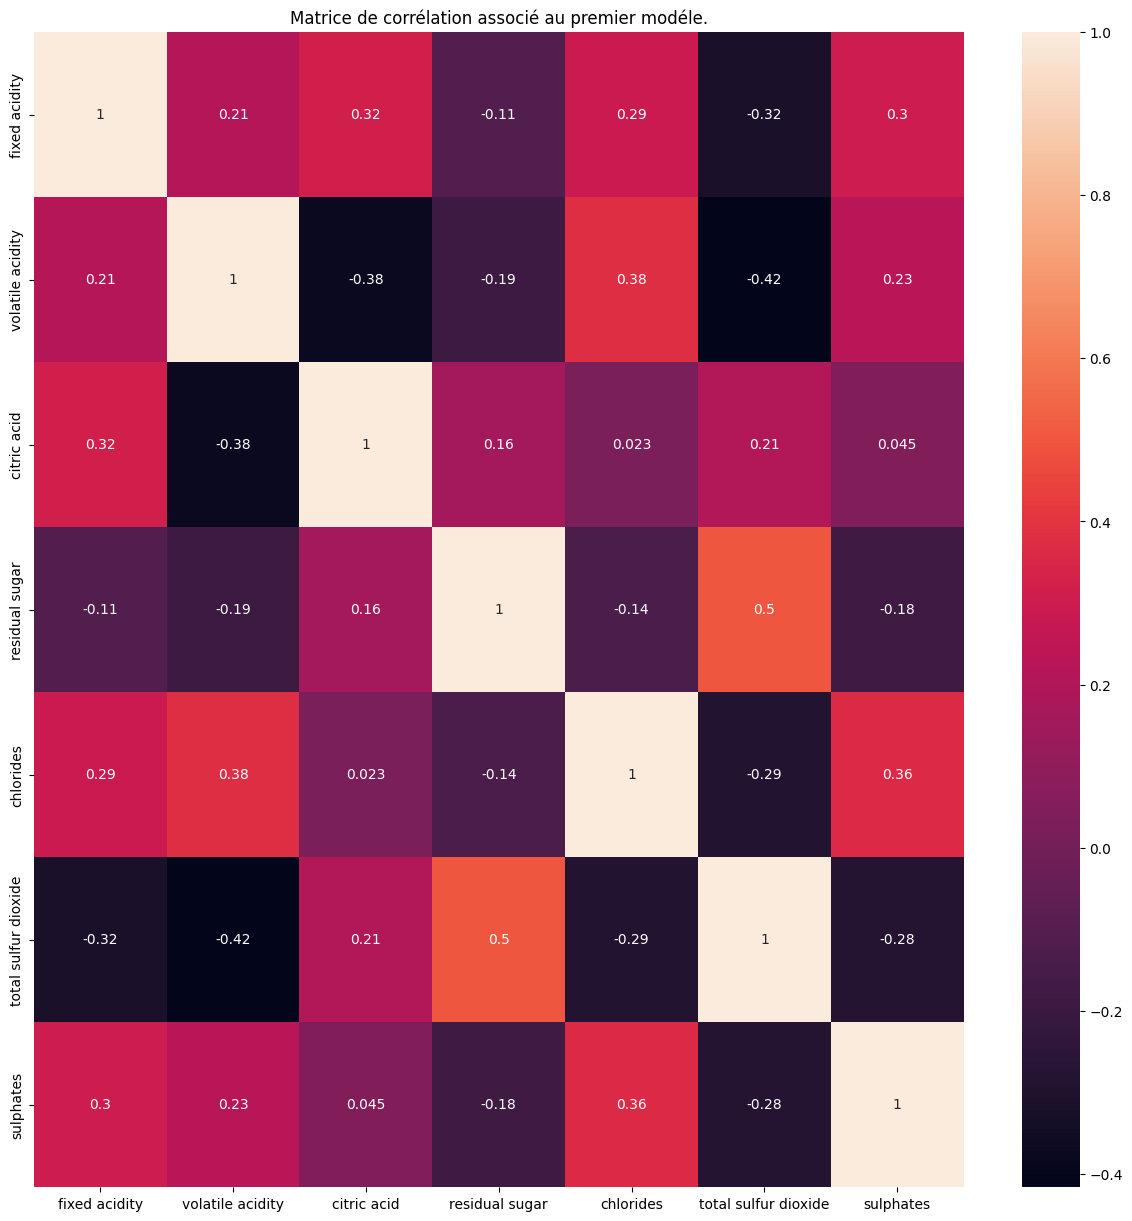

,variable,VIF
0,fixed acidity,29.467882
6,sulphates,15.770128
2,citric acid,9.113893
1,volatile acidity,8.053611
5,total sulfur dioxide,6.302553
4,chlorides,5.041018
3,residual sugar,3.127483


In [44]:
plt.figure(figsize=(15, 15))
sns.heatmap(X_train.corr(), annot=True)
plt.title("Matrice de corrélation associé au premier modéle.")
plt.show()


def compute_vif(df: pd.DataFrame) -> pd.DataFrame:
    Xc = df.select_dtypes(include=[np.number]).dropna()
    vifs = [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    out = pd.DataFrame({"variable": Xc.columns, "VIF": vifs})
    return out[out["variable"] != "const"].sort_values("VIF", ascending=False)


compute_vif(X_train)

On ne détecte aucune relation problématique dans la matrice de corrélation, mais de nombreuses valeurs de VIF sont supérieures à 5, ce qui indique un risque de multicolinéarité. Nous allons donc utiliser une régression logistique en comparant l’absence de régularisation avec les régularisations ridge et lasso. L’étape suivante consiste à identifier les meilleures techniques de normalisation.

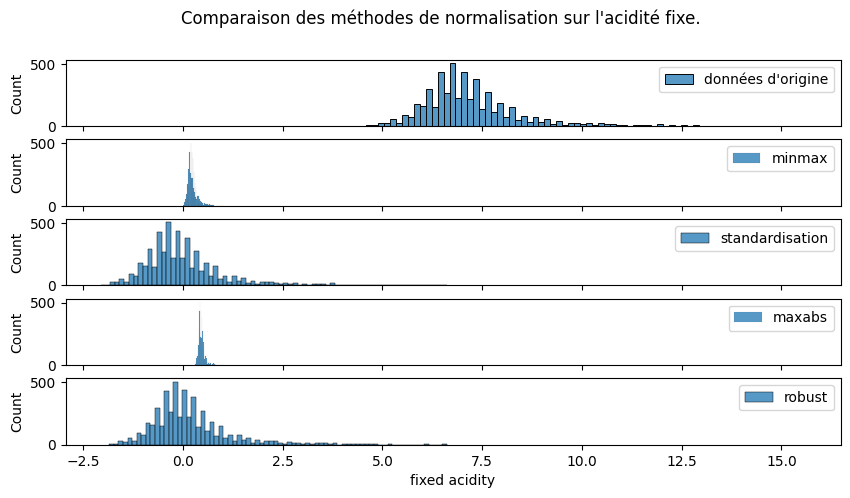

In [45]:
minmax = MinMaxScaler()
standard = StandardScaler()
maxabs = MaxAbsScaler()
robust = RobustScaler()

X_minmax = minmax.fit_transform(X_train)
X_standard = standard.fit_transform(X_train)
X_maxabs = maxabs.fit_transform(X_train)
X_robust = robust.fit_transform(X_train)

fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle("Comparaison des méthodes de normalisation sur l'acidité fixe.")
sns.histplot(data=X_train, x="fixed acidity", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="fixed acidity", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="fixed acidity", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="fixed acidity", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="fixed acidity", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

La standardisation est la meilleure option, car elle ne compresse pas excessivement les données.

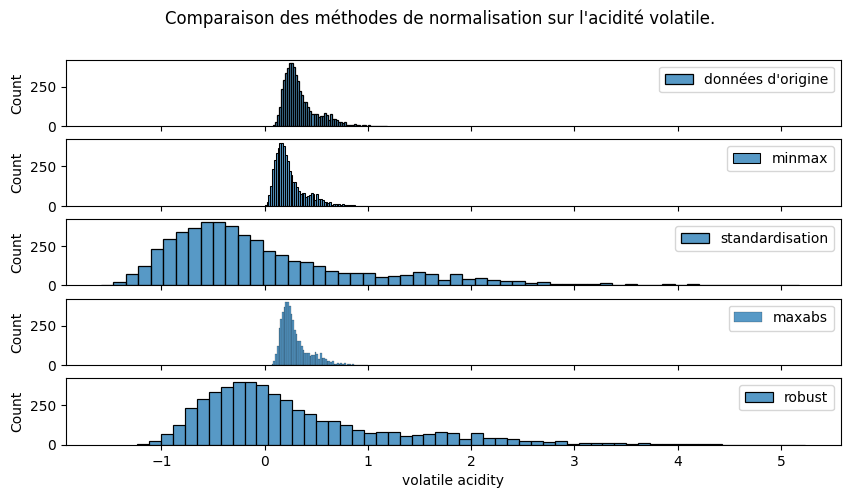

In [46]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle("Comparaison des méthodes de normalisation sur l'acidité volatile.")
sns.histplot(data=X_train, x="volatile acidity", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="volatile acidity", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="volatile acidity", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="volatile acidity", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="volatile acidity", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

La normalisation MinMax est la meilleure technique, car elle compresse moins les données que MaxAbs, tandis que les méthodes de standardisation et de RobustScaler les décompressent trop.

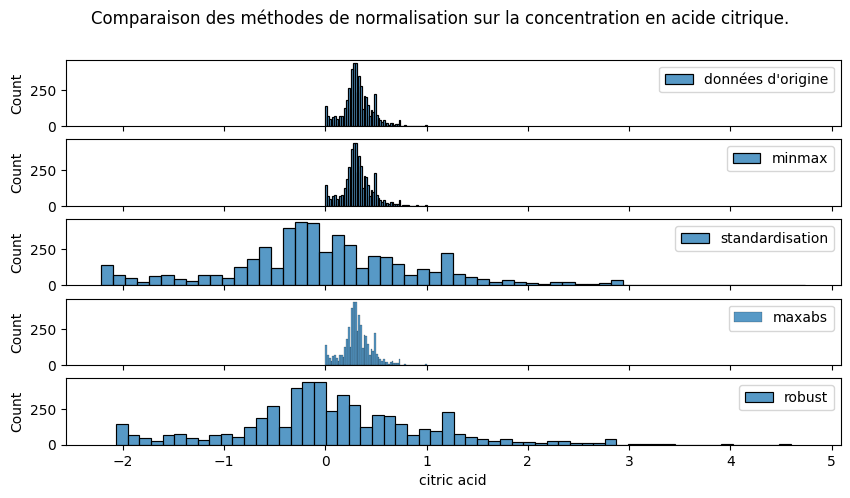

In [47]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration en acide citrique."
)
sns.histplot(data=X_train, x="citric acid", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="citric acid", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="citric acid", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="citric acid", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="citric acid", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

La mise à l’échelle MinMax est la plus adaptée, car cette variable est déjà normalisée entre 0 et 1.

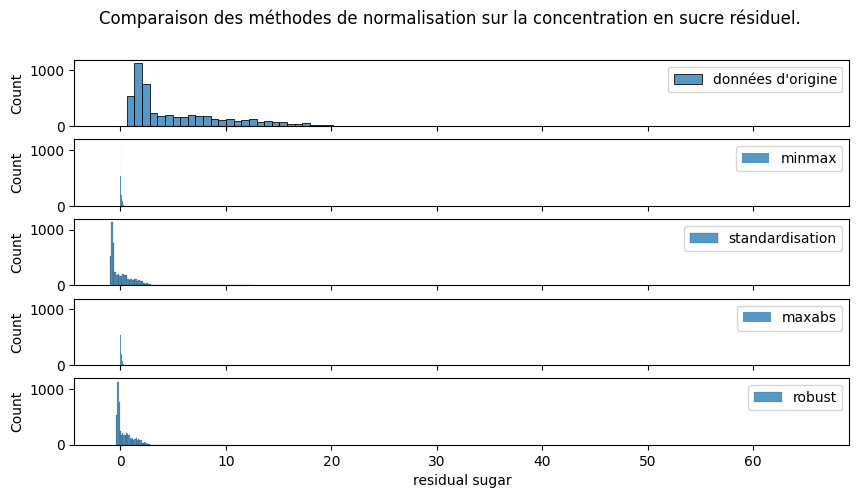

In [48]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration en sucre résiduel."
)
sns.histplot(data=X_train, x="residual sugar", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="residual sugar", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="residual sugar", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="residual sugar", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="residual sugar", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

Toutes les méthodes appliquées compriment les données. Celle qui les comprime le moins est la standardisation.

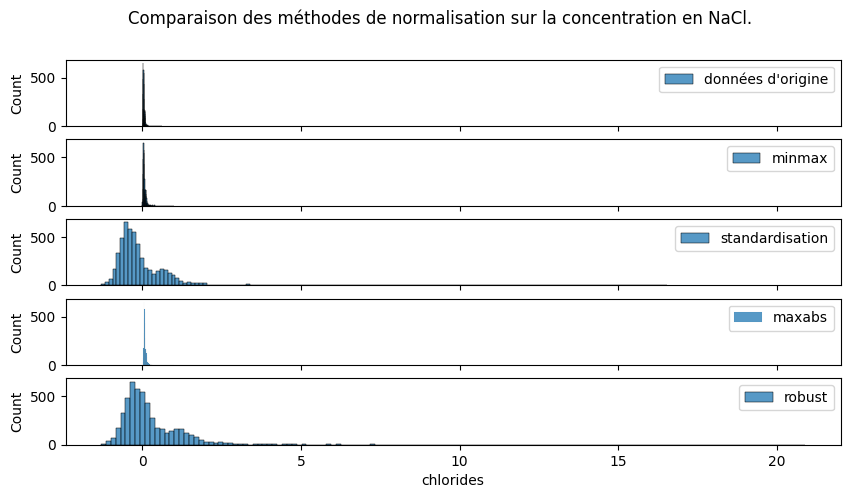

In [49]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle("Comparaison des méthodes de normalisation sur la concentration en NaCl.")
sns.histplot(data=X_train, x="chlorides", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="chlorides", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="chlorides", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="chlorides", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="chlorides", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

La mise à l’échelle MinMax préserve une répartition très proche des données d’origine, elle constitue donc la meilleure méthode.

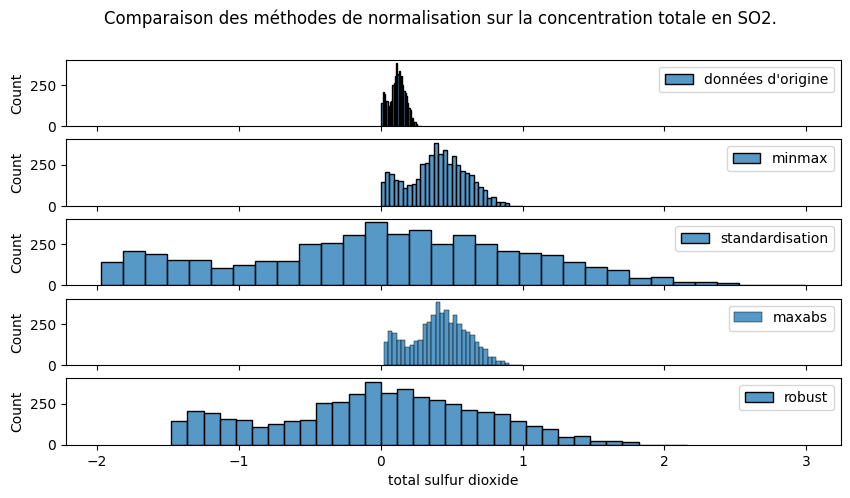

In [50]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration totale en SO2."
)
sns.histplot(
    data=X_train, x="total sulfur dioxide", label="données d'origine", ax=ax[0]
)
sns.histplot(data=X_minmax, x="total sulfur dioxide", label="minmax", ax=ax[1])
sns.histplot(
    data=X_standard, x="total sulfur dioxide", label="standardisation", ax=ax[2]
)
sns.histplot(data=X_maxabs, x="total sulfur dioxide", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="total sulfur dioxide", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

Toutes les techniques décompressent les données. Celle qui les décompresse le moins est MaxAbs, mais MaxAbs normalise entre -1 et 1 et, comme la majorité des valeurs se situe entre 0 et 1, cette majorité est concentrée sur seulement 50 % de l’intervalle. Nous allons donc utiliser MinMax.

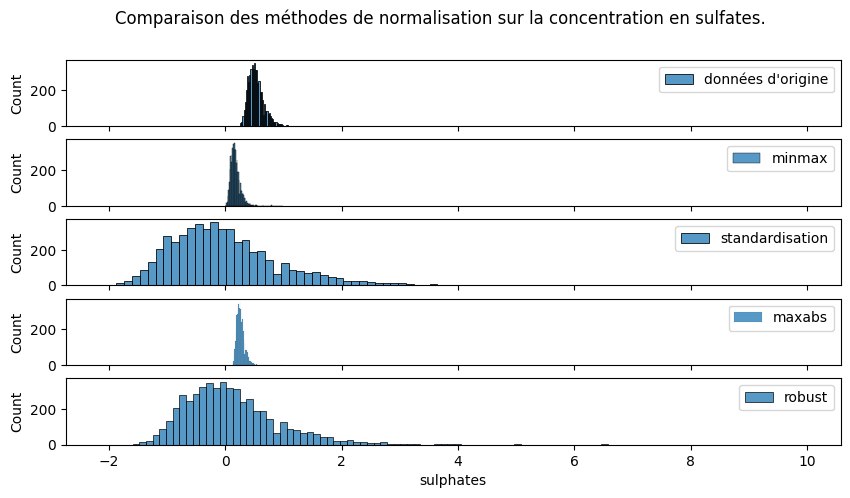

In [51]:
fig, ax = plt.subplots(5, 1, sharex=True)
fig.set_size_inches(10, 5)
plt.suptitle(
    "Comparaison des méthodes de normalisation sur la concentration en sulfates."
)
sns.histplot(data=X_train, x="sulphates", label="données d'origine", ax=ax[0])
sns.histplot(data=X_minmax, x="sulphates", label="minmax", ax=ax[1])
sns.histplot(data=X_standard, x="sulphates", label="standardisation", ax=ax[2])
sns.histplot(data=X_maxabs, x="sulphates", label="maxabs", ax=ax[3])
sns.histplot(data=X_robust, x="sulphates", label="robust", ax=ax[4])
for axi in ax:
    axi.legend()
plt.show()

Le résultat qui se rapproche le plus du jeu de données initial est obtenu avec la normalisation MinMax.

In [52]:
normaliser = ColumnTransformer(
    [
        ("standard", StandardScaler(), ["fixed acidity", "residual sugar"]),
        (
            "minmax",
            MinMaxScaler(),
            [
                "volatile acidity",
                "citric acid",
                "chlorides",
                "total sulfur dioxide",
                "sulphates",
            ],
        ),
    ],
    verbose_feature_names_out=False,
)

In [53]:
pipeline = make_pipeline(normaliser)
pipeline

,steps,"[('columntransformer', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('standard', ...), ('minmax', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [54]:
X_train_preprocessed = pipeline.fit_transform(X_train)
X_train_preprocessed

,fixed acidity,residual sugar,volatile acidity,citric acid,chlorides,total sulfur dioxide,sulphates
2618,0.861406,-0.833135,0.054545,0.26,0.061770,0.663043,0.227273
2359,-0.244664,0.544944,0.090909,0.38,0.061770,0.615942,0.181818
4924,-0.323669,-0.102336,0.154545,0.28,0.038397,0.434783,0.090909
6351,-1.666755,-0.874895,0.154545,0.36,0.038397,0.260870,0.238636
153,0.229366,-0.770496,0.472727,0.03,0.138564,0.336957,0.181818
...,...,...,...,...,...,...,...
3803,0.308371,-0.728736,0.172727,0.33,0.078464,0.612319,0.193182
5232,-0.481679,0.524064,0.200000,0.25,0.040067,0.427536,0.090909
5267,-0.560684,1.150463,0.172727,0.26,0.030050,0.275362,0.079545
5431,-0.323669,-0.415536,0.209091,0.19,0.123539,0.449275,0.125000


{'C': np.float64(10000.0), 'penalty': 'l2', 'solver': 'lbfgs'}
0.9736961540187451


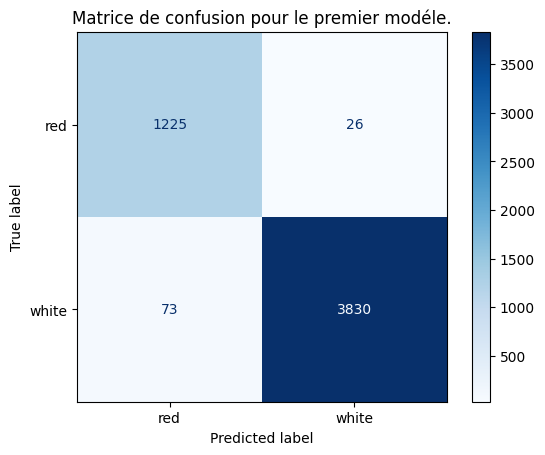

In [55]:
C_vals_ext = np.logspace(-5, 5, 11)

param_grid = [
    {
        "solver": ["lbfgs", "newton-cg"],
        "penalty": ["l2"],
        "C": C_vals_ext,
    },
    {
        "solver": ["lbfgs", "newton-cg"],
        "penalty": [None],
    },
    {
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
        "C": C_vals_ext,
    },
]

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

grid = GridSearchCV(
    estimator=LogisticRegression(
        random_state=42, max_iter=900, class_weight="balanced"
    ),
    param_grid=param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    error_score="raise",
)

grid.fit(X_train_preprocessed, y_train)
print(grid.best_params_)
print(grid.best_score_)
model1 = grid.best_estimator_
cm = confusion_matrix(y_train, model1.predict(X_train_preprocessed))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion pour le premier modéle.")
plt.show()

On observe que, sur le jeu d’entraînement, notre modèle se trompe pour 99 vins et prédit correctement 5055 vins. On constate également qu’il est plus performant pour prédire les vins blancs que les vins rouges.

In [56]:
print(classification_report(y_train, model1.predict(X_train_preprocessed), digits=5))

              precision    recall  f1-score   support

         red    0.94376   0.97922   0.96116      1251
       white    0.99326   0.98130   0.98724      3903

    accuracy                        0.98079      5154
   macro avg    0.96851   0.98026   0.97420      5154
weighted avg    0.98124   0.98079   0.98091      5154



Nous atteignons tous les objectifs sur le jeu d’entraînement pour un enjeu moyen élevé mais réel.

In [57]:
print(
    "roc_auc_score: ",
    roc_auc_score(y_train, model1.predict_proba(X_train_preprocessed)[:, 1]),
)

roc_auc_score:  0.996186704236406


Nous avons largement atteint notre objectif en termes de ROC AUC. Nous allons donc passer au test.

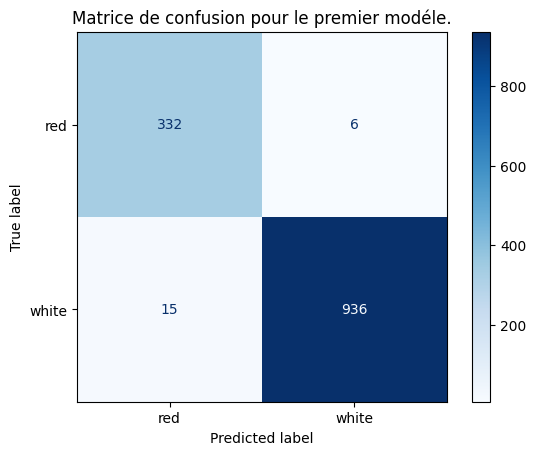

              precision    recall  f1-score   support

         red    0.95677   0.98225   0.96934       338
       white    0.99363   0.98423   0.98891       951

    accuracy                        0.98371      1289
   macro avg    0.97520   0.98324   0.97912      1289
weighted avg    0.98397   0.98371   0.98378      1289

roc_auc_score:  0.9955605746675874


In [58]:
X_test_preprocessed = pipeline.transform(X_test)
cm = confusion_matrix(y_test, model1.predict(X_test_preprocessed))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion pour le premier modéle.")
plt.show()
print(classification_report(y_test, model1.predict(X_test_preprocessed), digits=5))
print(
    "roc_auc_score: ",
    roc_auc_score(y_test, model1.predict_proba(X_test_preprocessed)[:, 1]),
)

On constate que notre modèle est largement au dessus des objectifs fixés pour un enjeu de niveau moyen à élevé, par exemple pour détecter des fraudes potentielles de faux vins blancs. Notre modèle est plus performant sur les vins blancs que sur les vins rouges, mais les erreurs restent acceptables. Nous allons maintenant construire les intervalles de confiance.

# IV) Intervalles de confiance

In [59]:
p_accuraccy = 0.98371
p_precision_red = 0.95677
p_precision_white = 0.99363
p_recall_red = 0.98225
p_recall_white = 0.98423
p_f1_red = 0.96934
p_f1_white = 0.98891
p_auc = 0.99556


def intervalle_confiance(p, n, z):
    se = np.sqrt((p * (1 - p)) / n)
    return [p - (z * se), p + (z * se)]


z = 2.576
n = len(X_test_preprocessed)
print("accuracy: ", intervalle_confiance(p_accuraccy, n, z))
print("precision red: ", intervalle_confiance(p_precision_red, n, z))
print("precision white: ", intervalle_confiance(p_precision_white, n, z))
print("recall red: ", intervalle_confiance(p_recall_red, n, z))
print("recall white: ", intervalle_confiance(p_recall_white, n, z))
print("f1 red: ", intervalle_confiance(p_f1_red, n, z))
print("f1 white: ", intervalle_confiance(p_f1_white, n, z))
print("auc roc: ", intervalle_confiance(p_auc, n, z))

accuracy:  [np.float64(0.9746273310453071), np.float64(0.9927926689546929)]
precision red:  [np.float64(0.9421779673594808), np.float64(0.9713620326405192)]
precision white:  [np.float64(0.9879217699976136), np.float64(0.9993382300023864)]
recall red:  [np.float64(0.9727760825233822), np.float64(0.9917239174766177)]
recall white:  [np.float64(0.9752911109685699), np.float64(0.9931688890314302)]
f1 red:  [np.float64(0.9569707450120218), np.float64(0.9817092549879781)]
f1 white:  [np.float64(0.9813961320683804), np.float64(0.9964238679316195)]
auc roc:  [np.float64(0.9907897119474661), np.float64(1.000330288052534)]


Nous avons 99 % de chances que nos différentes métriques se situent dans les intervalles précédemment estimés.

# V) Applicabilité

Notre modèle est applicable à tous les vins Vinho Verde portugais qui respectent les normes AOP officielles.